In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100

In [3]:
infoLocation = "/Users/weilu/Research/database/hybrid_prediction_database/length_info.csv"
info = pd.read_csv(infoLocation, index_col=0)

In [11]:
def getContactMap(pdb):
    fileLocation = f"/Users/weilu/Research/raptorX/{pdb}/contactmap.txt"
    data = pd.read_csv(fileLocation, skiprows=6, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
    data["i"] = data["i"].astype(int)
    data["j"] = data["j"].astype(int)
    n = int(info.query(f"Protein =='{pdb}'")["Length"])
    t = np.zeros((n,n))
    for index, d in data.iterrows():
    #     print(index)
        i = int(d["i"]) - 1
        j = int(d["j"]) - 1 
        p = d["p"]
    #     print(i,j,p)
        t[i,j] = p
        t[j,i] = p
#     topFile = f"/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation/TM_pred/{pdb}_topo"
#     MembranePart, GlobularPart = get_two_part_from_prediction(topFile)
    return t

def getContactMapFromPDB(pdbFile):
    cutoff = 9.5
    MAX_OFFSET = 6
    parser = PDBParser()
    structure = parser.get_structure('target', pdbFile)
    all_residues = list(structure.get_residues())
    
    tmp = []
    for res in all_residues:
        # print(res.id)
        if res.id[0] == ' ':
            tmp.append(res)

    all_residues = tmp

    n = len(all_residues)
    contact_table = np.zeros((n,n))
    # print(all_residues, n)
    for i, res1 in enumerate(all_residues):
        for j, res2 in enumerate(all_residues):
            contact_table[i][j] = res1["CA"]-res2["CA"]

    data = (contact_table < cutoff)
    remove_band = np.eye(n)
    for i in range(1, MAX_OFFSET):
        remove_band += np.eye(n, k=i)
        remove_band += np.eye(n, k=-i)
    data[remove_band==1] = 0
    return data


In [5]:
infoLocation = "/Users/weilu/Research/database/hybrid_prediction_database/length_info.csv"
info = pd.read_csv(infoLocation, index_col=0)
# get_two_part_from_eye
part_info = pd.read_csv("/Users/weilu/Research/database/hybrid_prediction_database/part_info.csv", names=["Protein", "Range"])
part_info = part_info.merge(info, on="Protein")

2xov_complete 1 63
2xov_complete 276
6e67A 201 380
6e67A 457
5xpd 218 269
5xpd 269
3kp9 165 259
3kp9 259
4a2n 101 125
4a2n 192
5d91 1 131
5d91 335
4nv6 167 258
4nv6 264
4p79 31 61
4p79 181
5dsg 205 311
5dsg 392
6g7o 245 350
6g7o 350
6a93 196 284
6a93 370
2jo1 45 72
2jo1 72
1py6 60 75
1py6 227
1pv6 190 219
1pv6 417
1u19 310 348
1u19 348


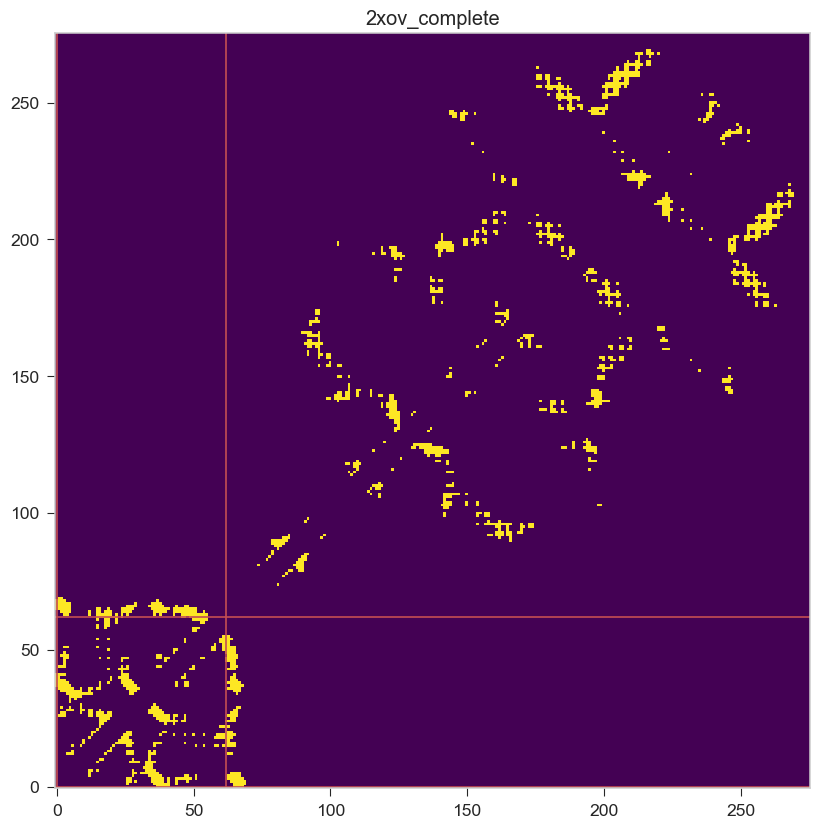

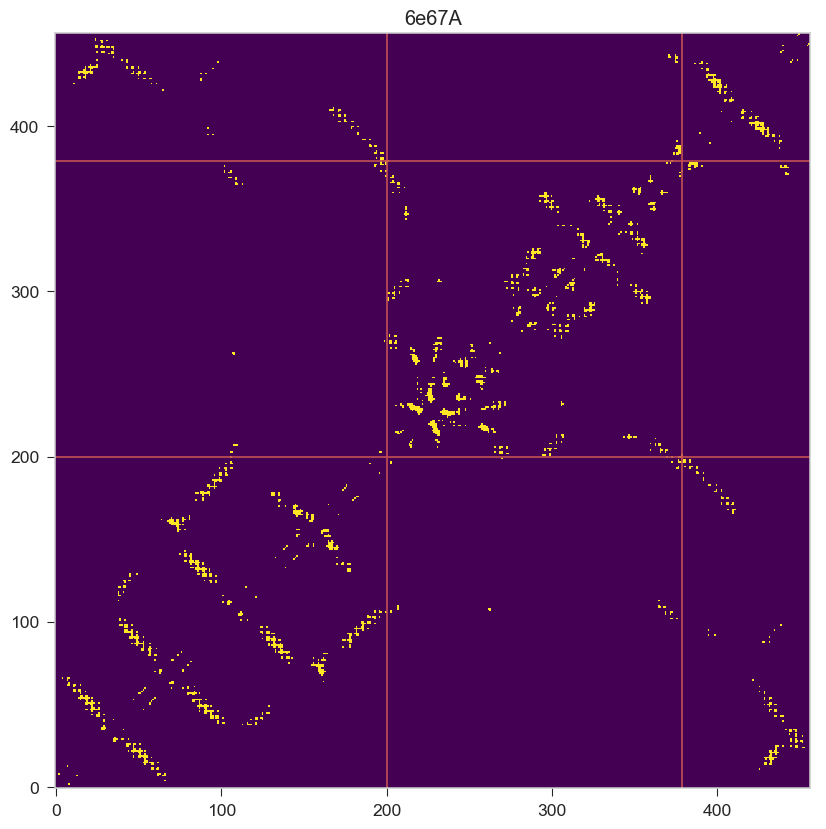

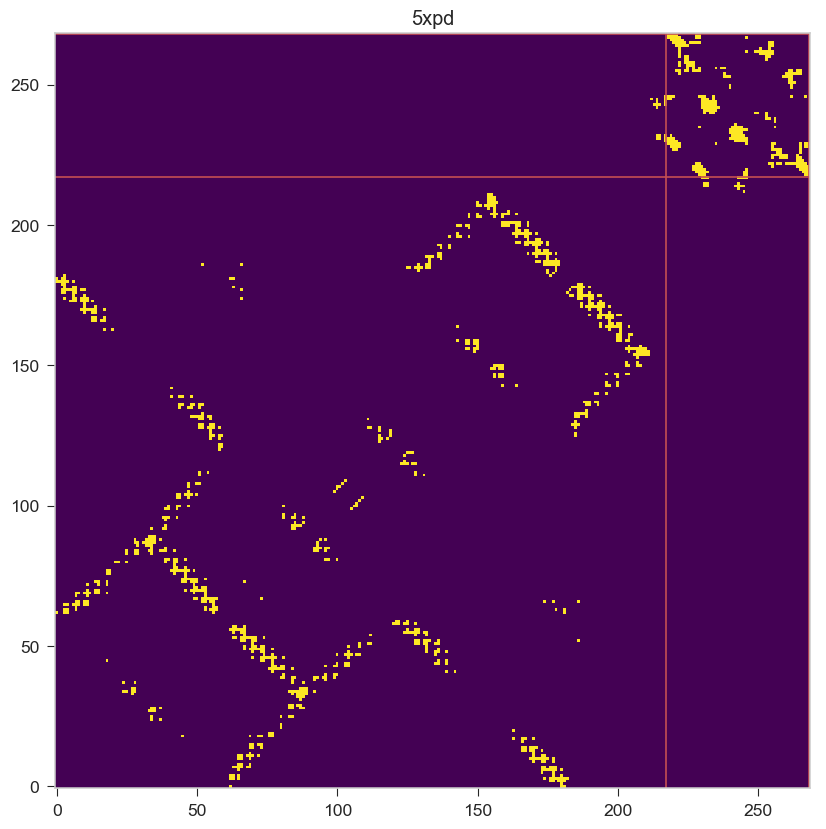

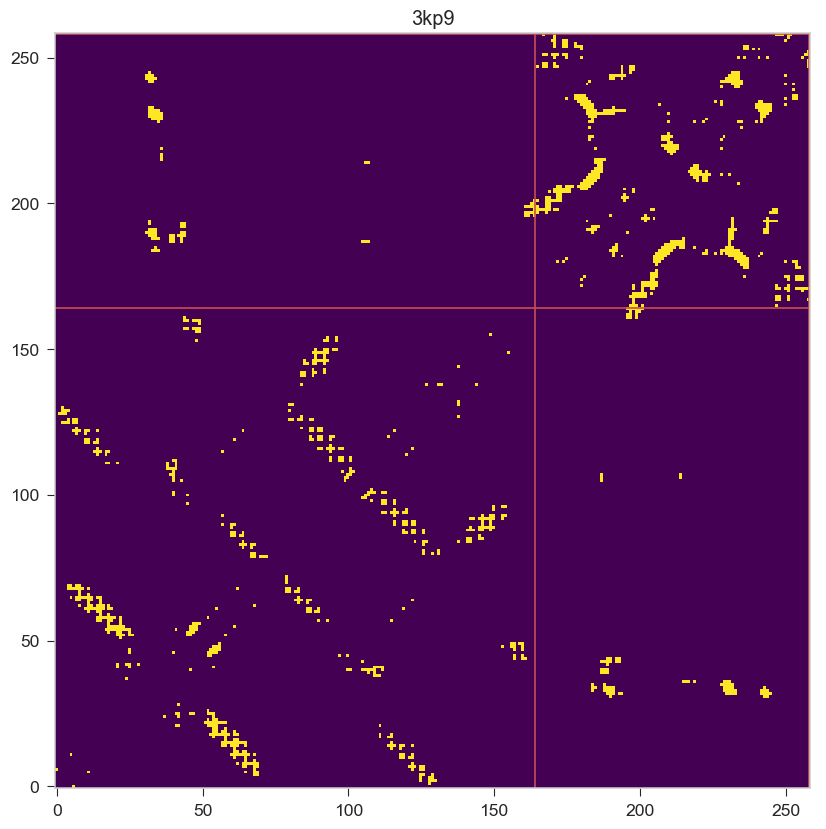

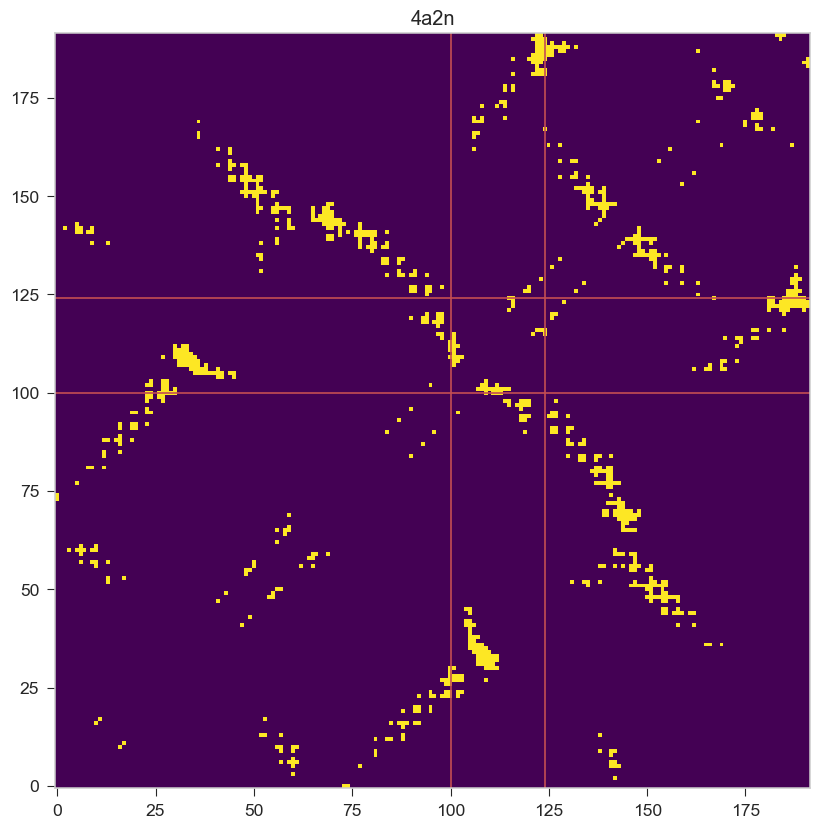

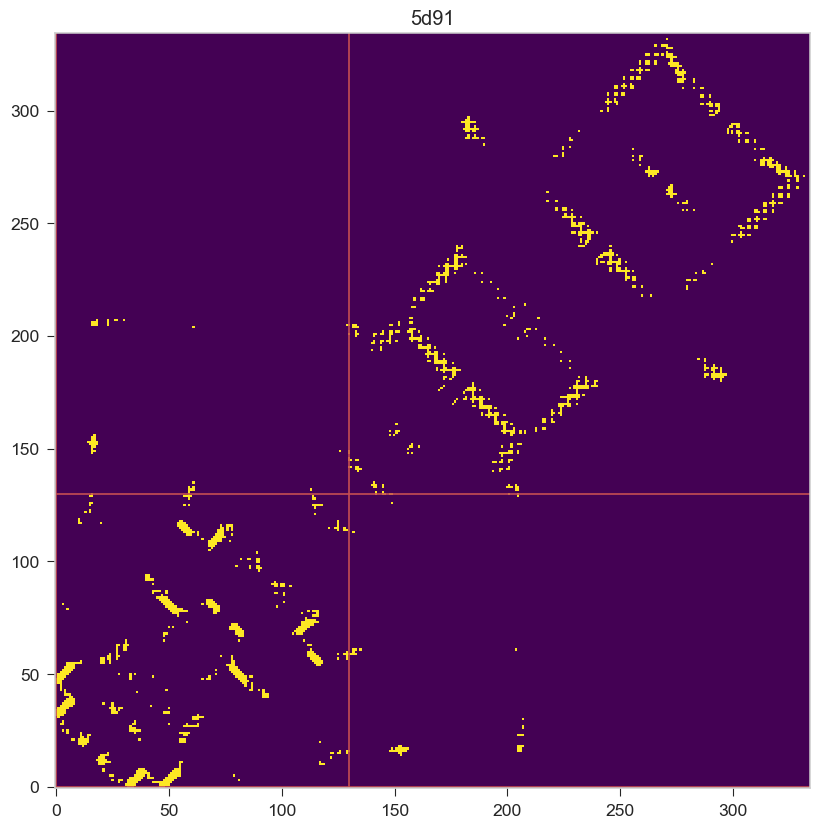

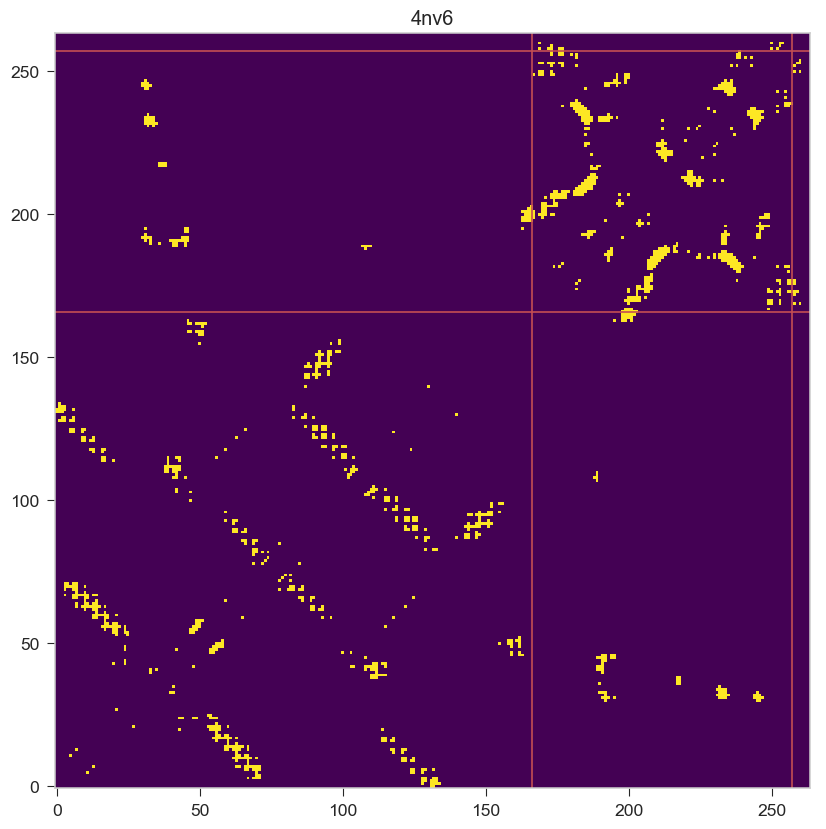

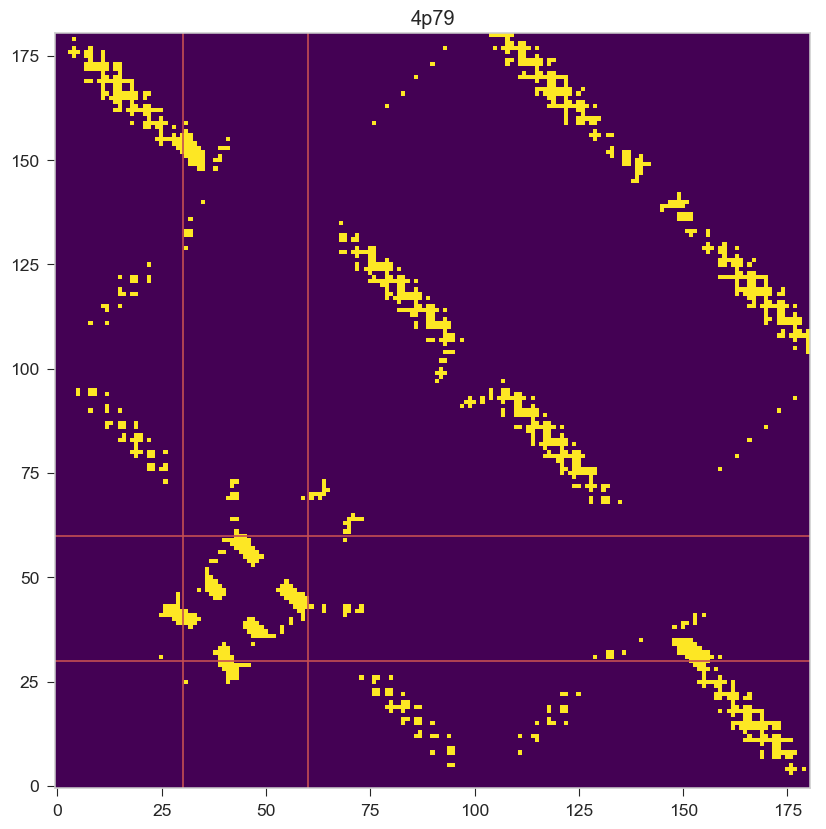

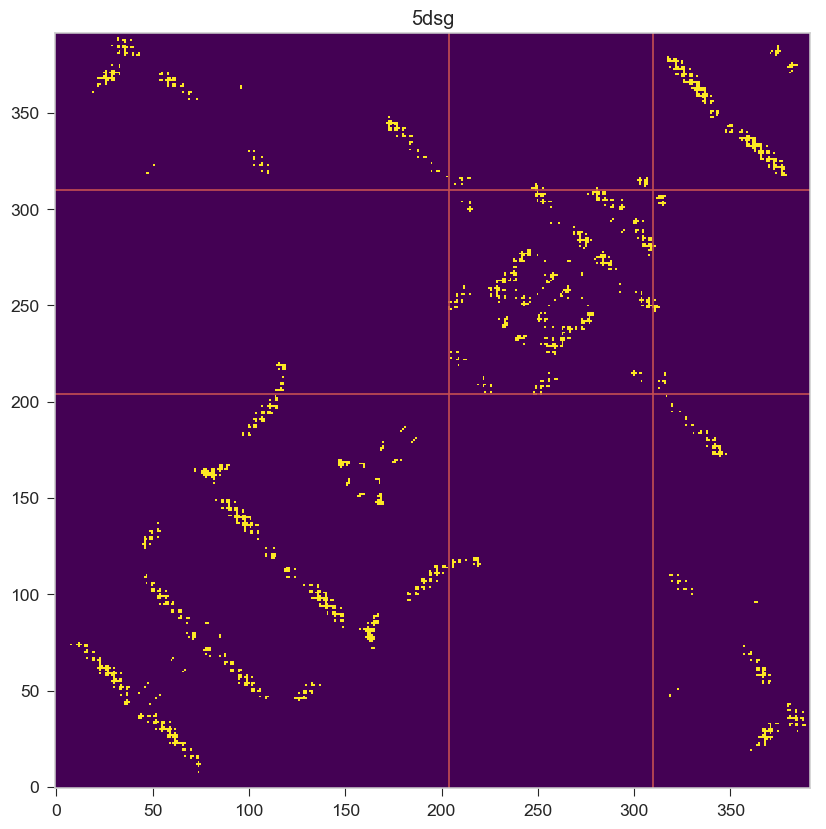

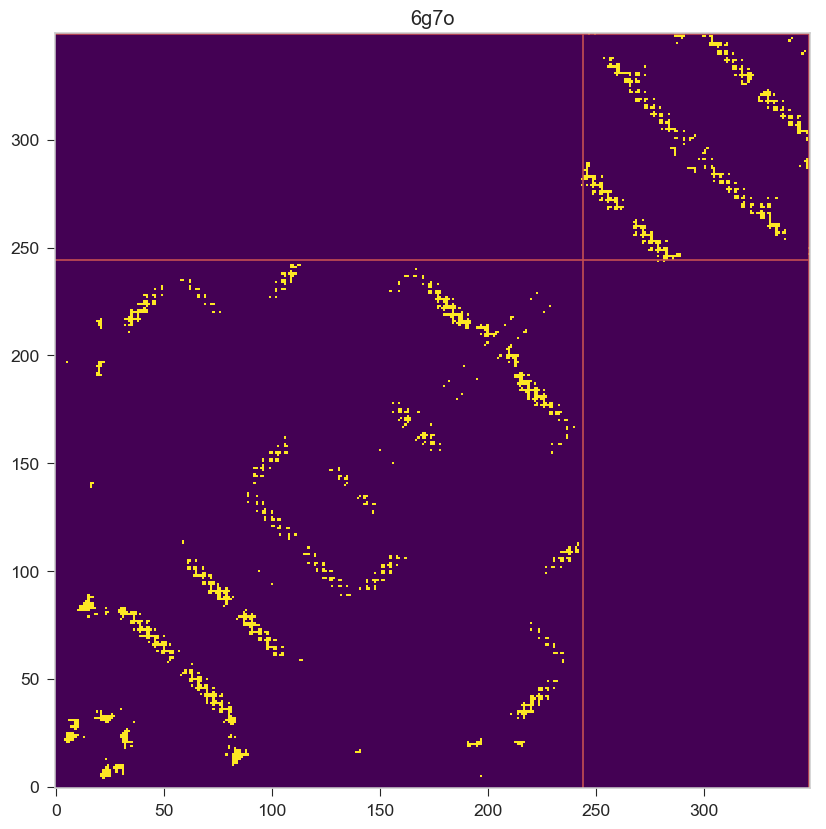

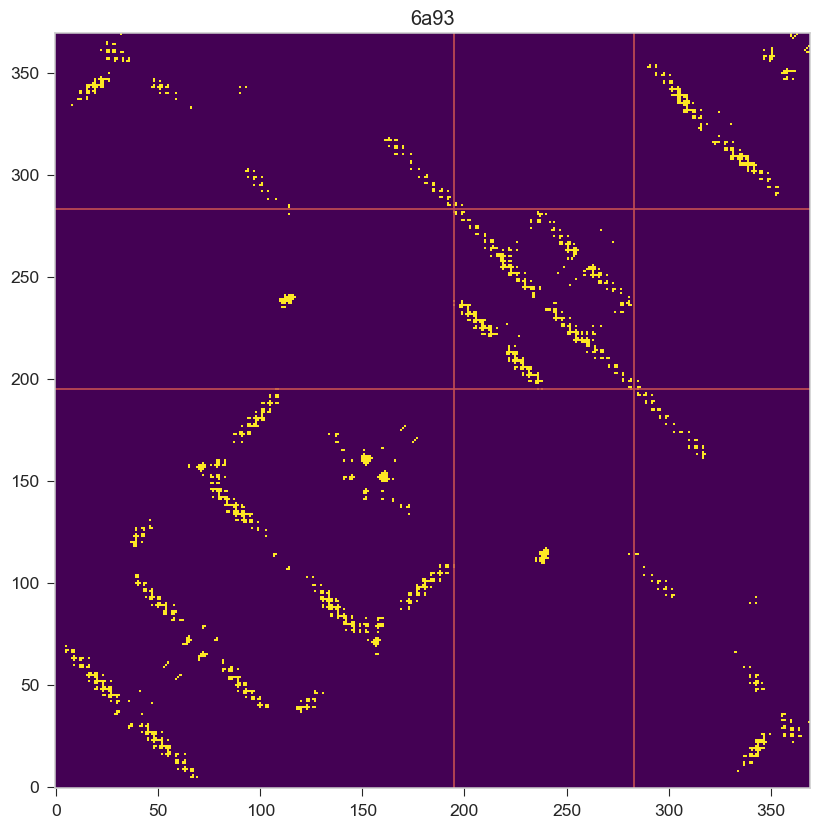

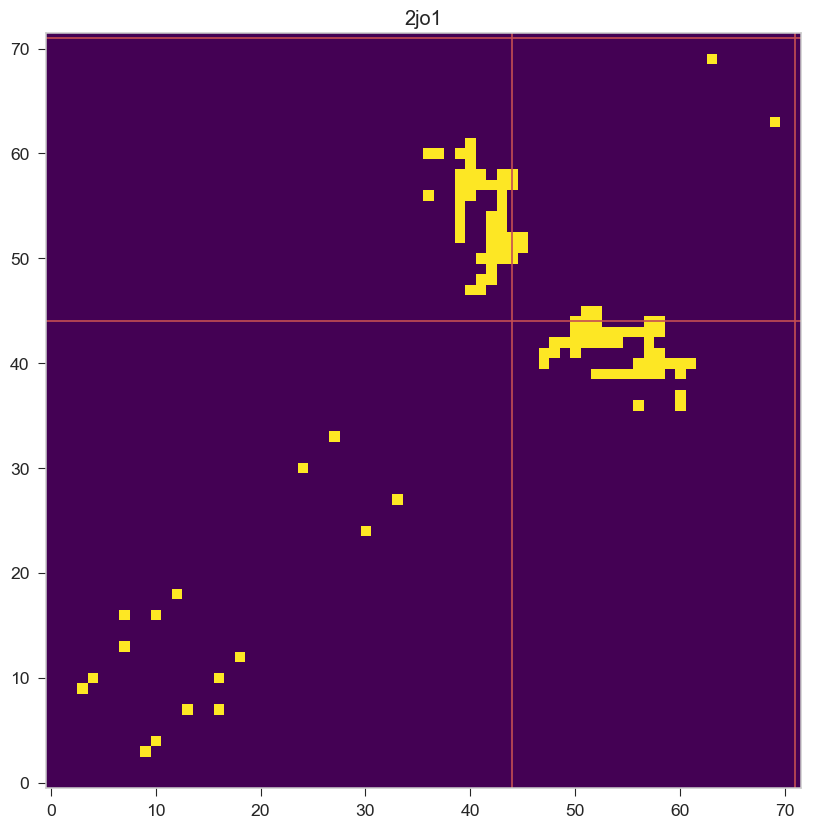

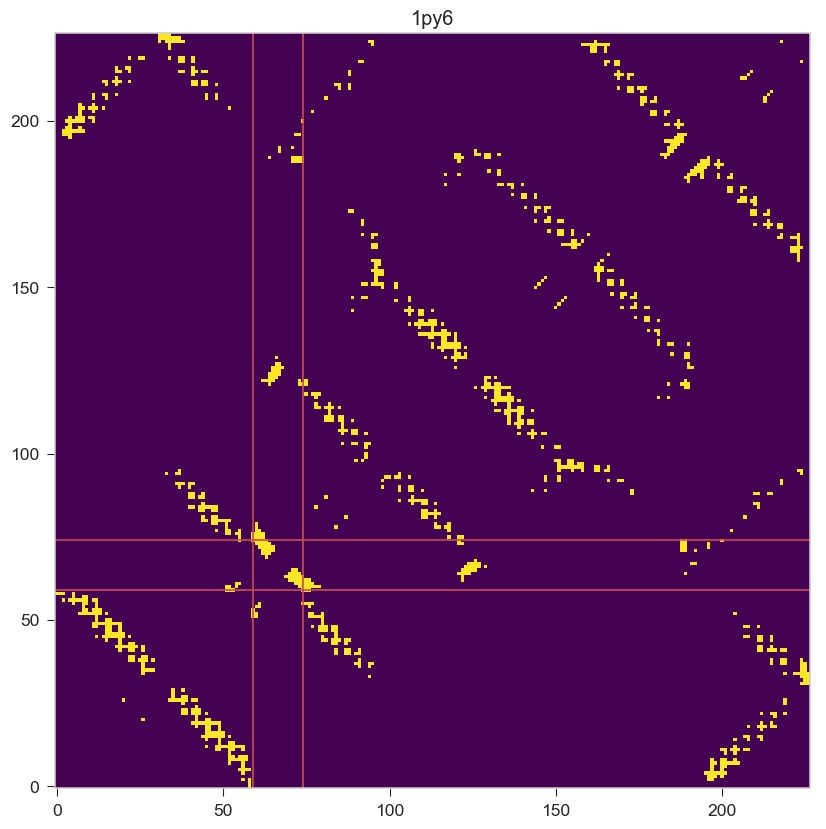

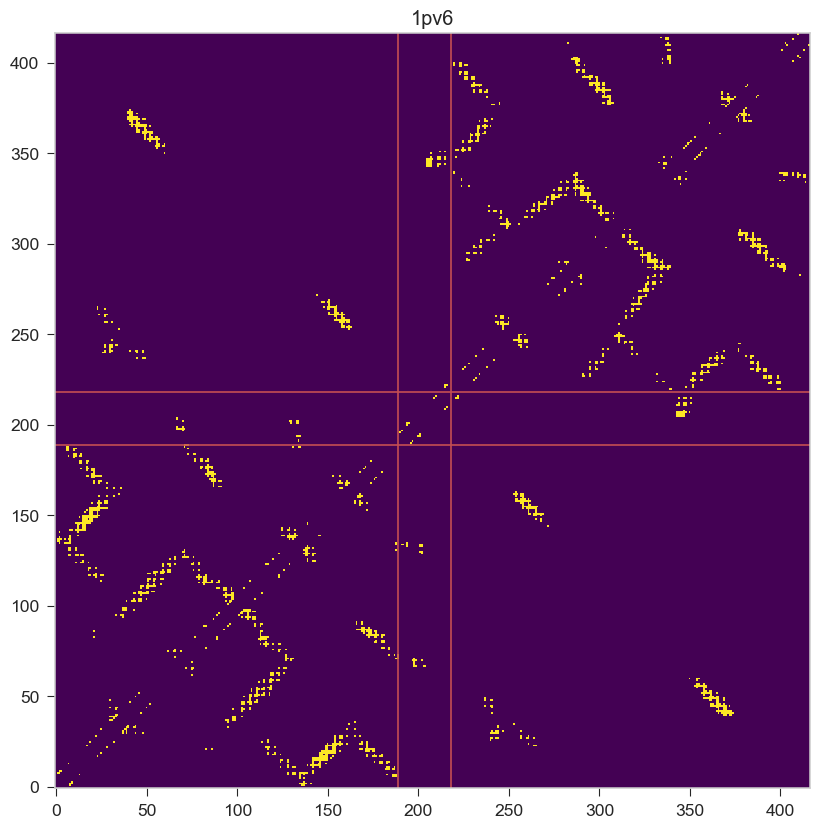

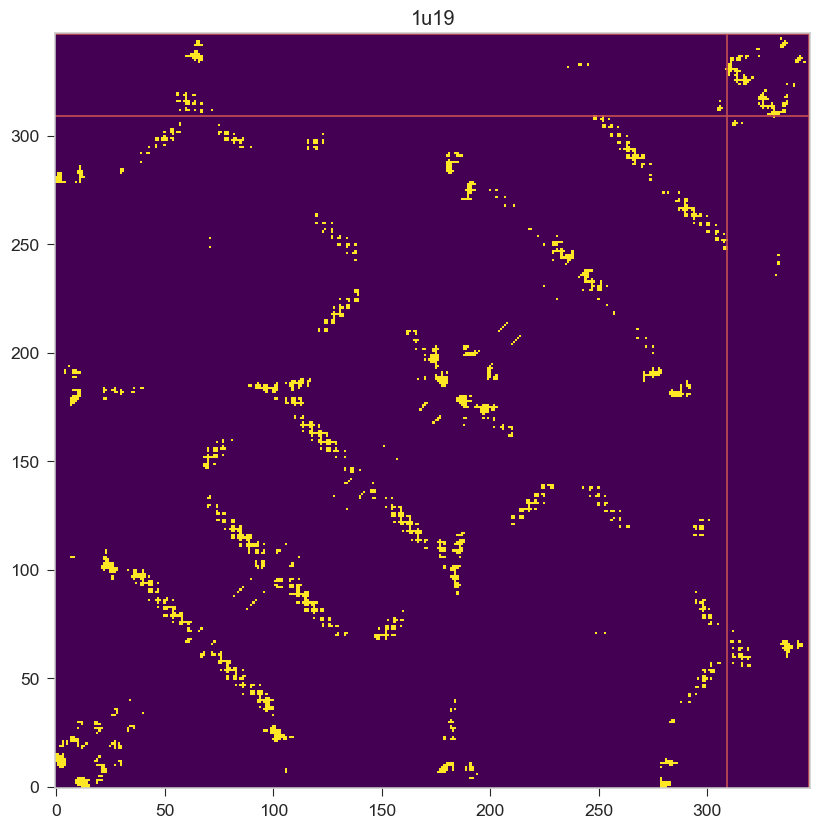

<Figure size 1618.03x1000 with 0 Axes>

In [9]:
for i, row in part_info.iterrows():
    pdb = row["Protein"]
    glob_start, glob_end = row["Range"].split("-")
    length = row["Length"]
    glob_start = int(glob_start)
    glob_end = int(glob_end)
    print(pdb, glob_start, glob_end)
    GlobularPart = list(range(glob_start, glob_end+1))
    MembranePart = []
    for i in range(1, length+1):
        if i not in GlobularPart:
            MembranePart.append(i)
    fileLocation = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/cleaned_pdbs/{pdb}.pdb"
    data = getContactMapFromPDB(fileLocation)
    plt.imshow(data, origin="bottom")
#     plt.colorbar()
    plt.axhline(y=GlobularPart[0]-1, color='r', linestyle='-')
    plt.axhline(y=GlobularPart[-1]-1, color='r', linestyle='-')
    plt.axvline(x=GlobularPart[0]-1, color='r', linestyle='-')
    plt.axvline(x=GlobularPart[-1]-1, color='r', linestyle='-')
    plt.title(pdb)
    plt.savefig(f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/contact_maps/{pdb}.png")
    plt.figure()

2xov_complete 1 63
6e67A 201 380
5xpd 218 269
3kp9 165 259
4a2n 101 125
5d91 1 131
4nv6 167 258
4p79 31 61
5dsg 205 311
6g7o 245 350
6a93 196 284
2jo1 45 72
1py6 60 75
1pv6 190 219
1u19 310 348


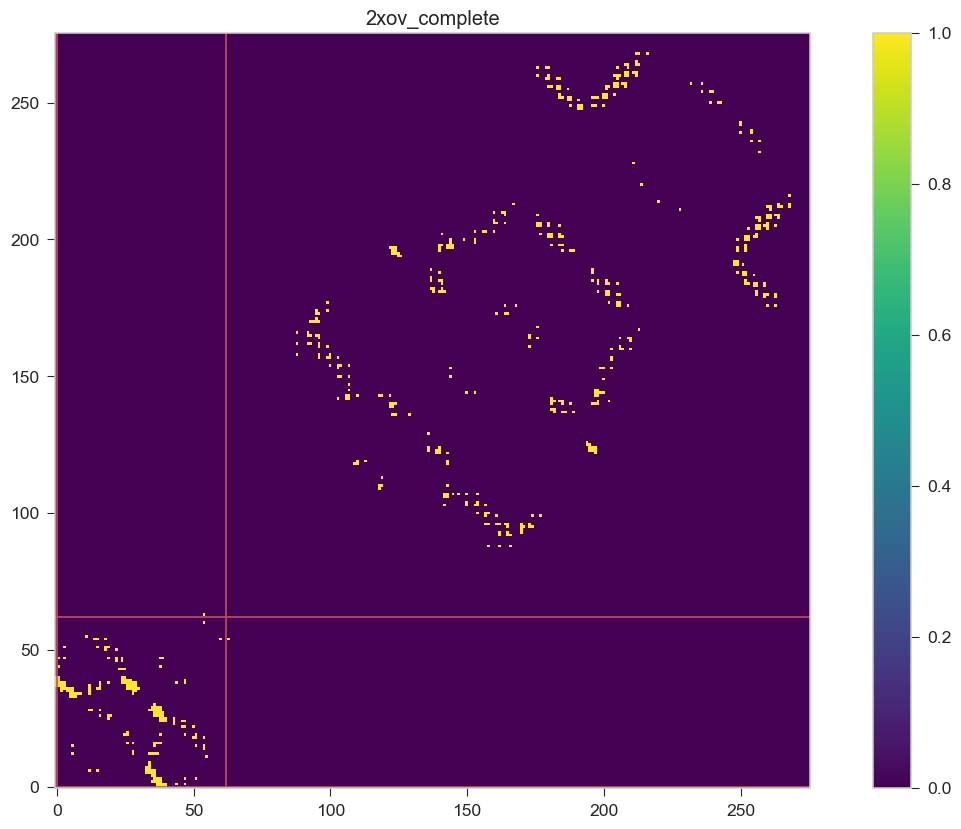

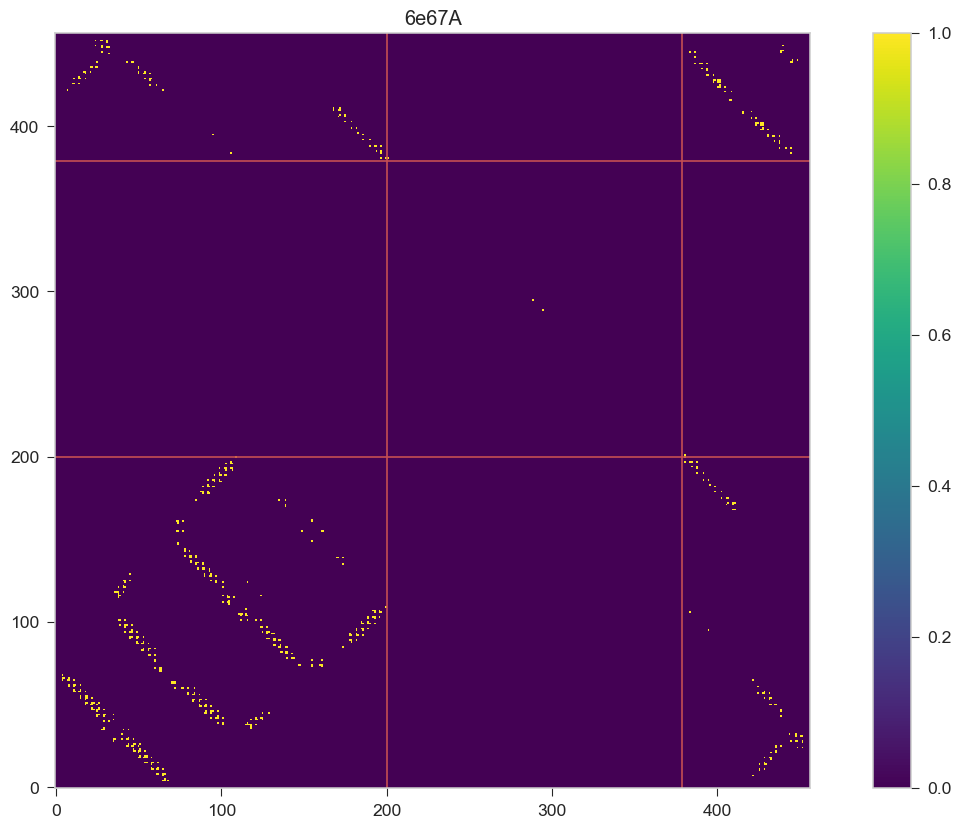

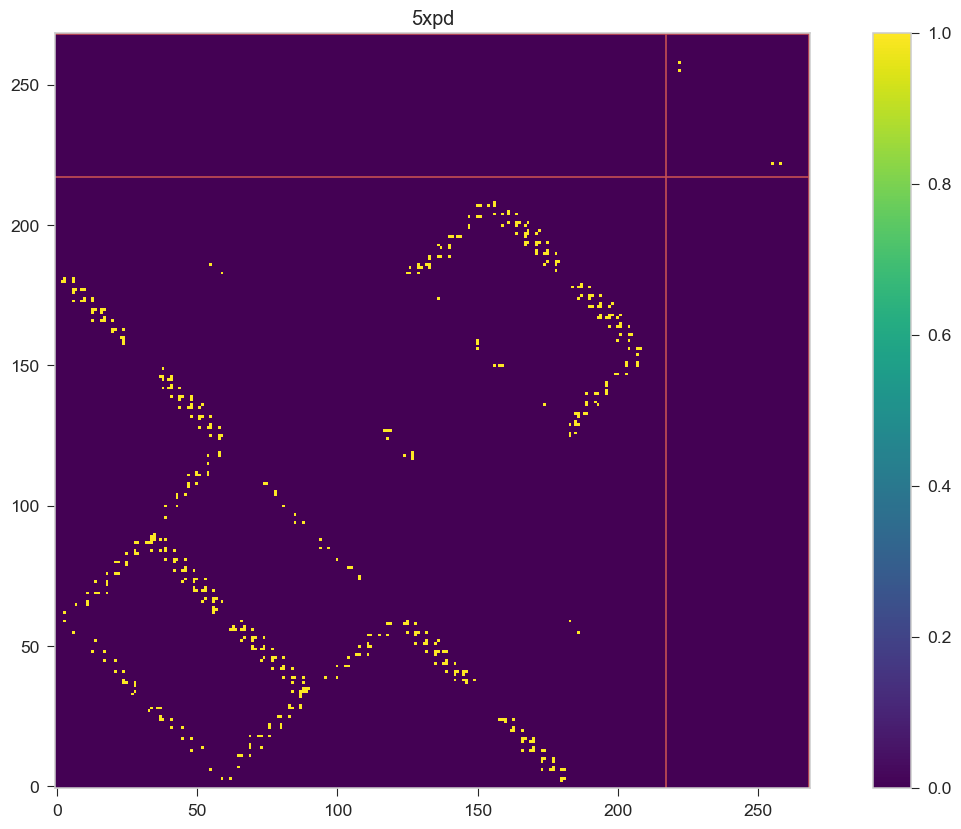

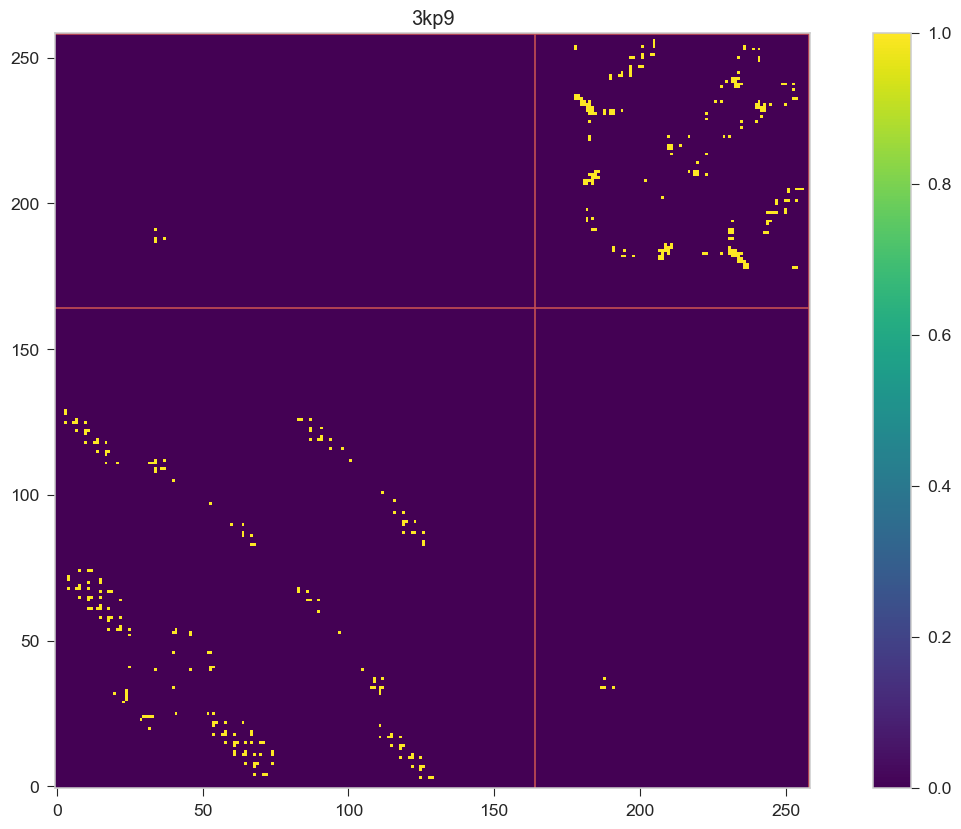

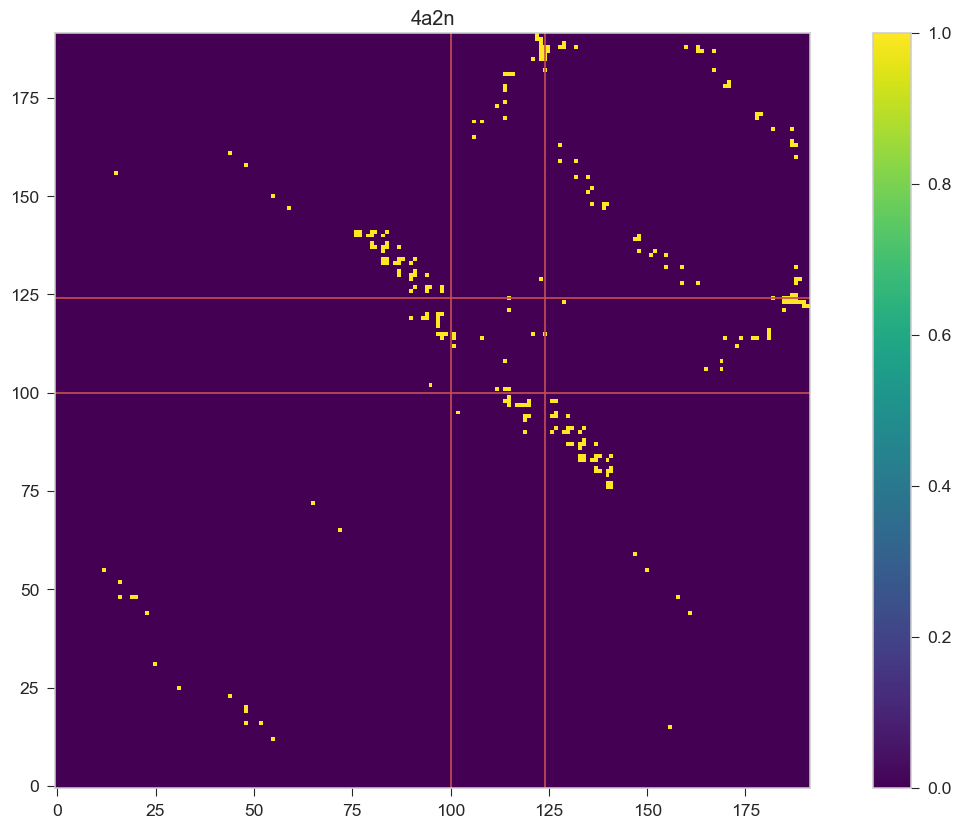

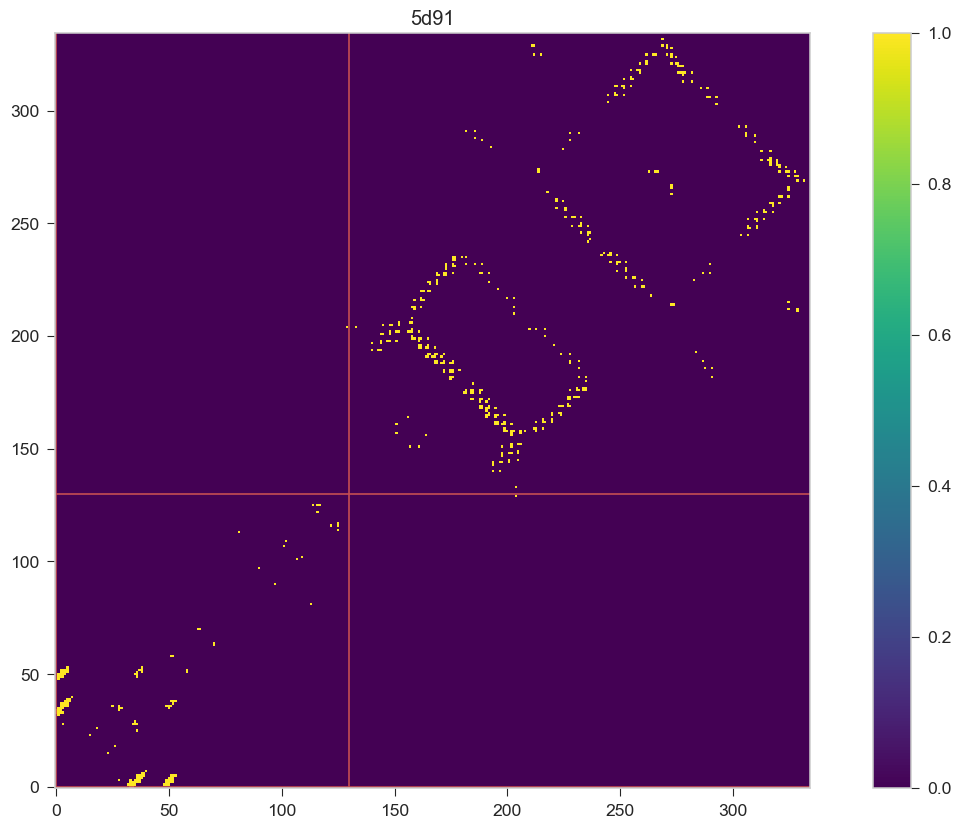

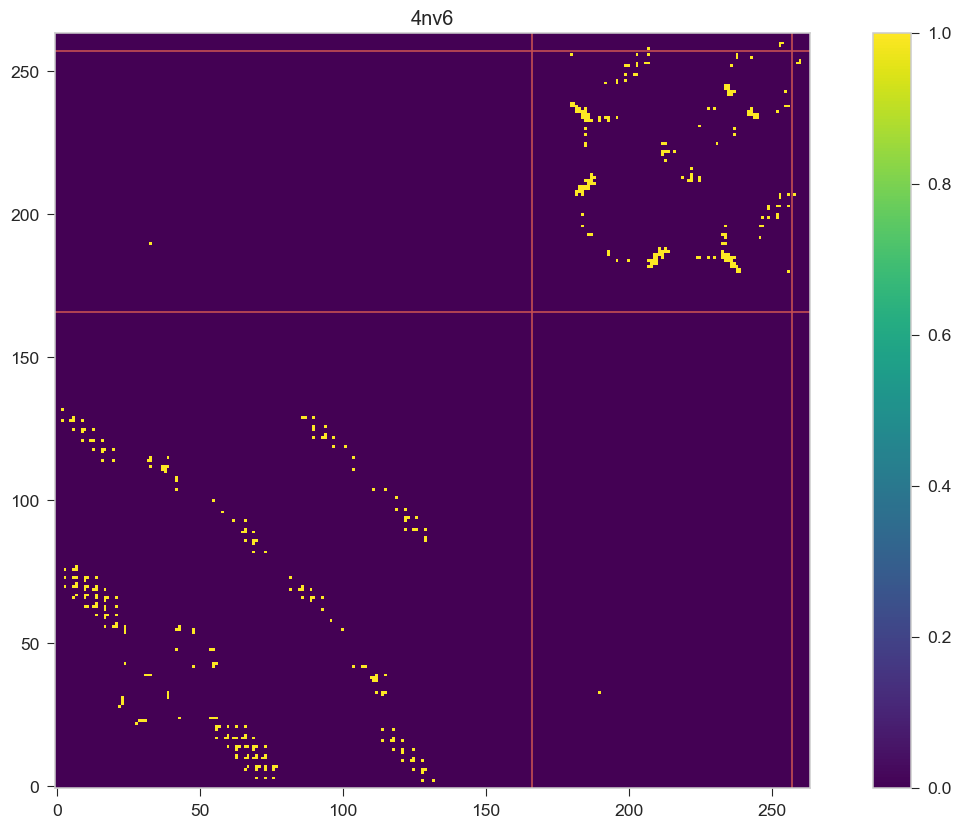

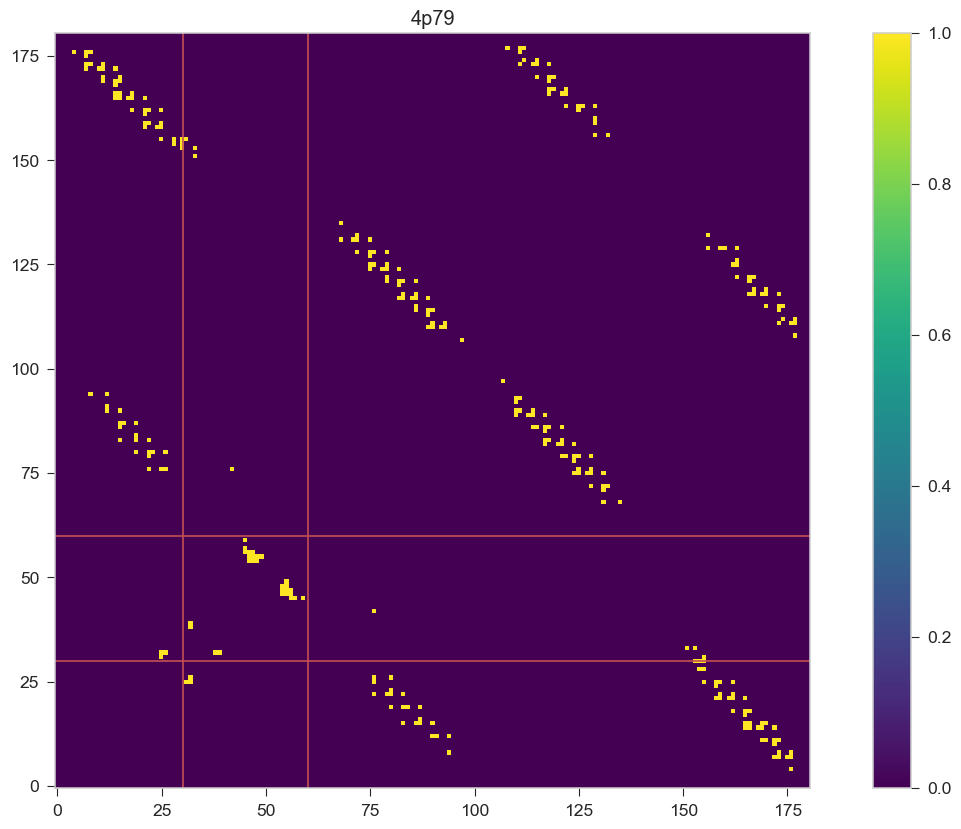

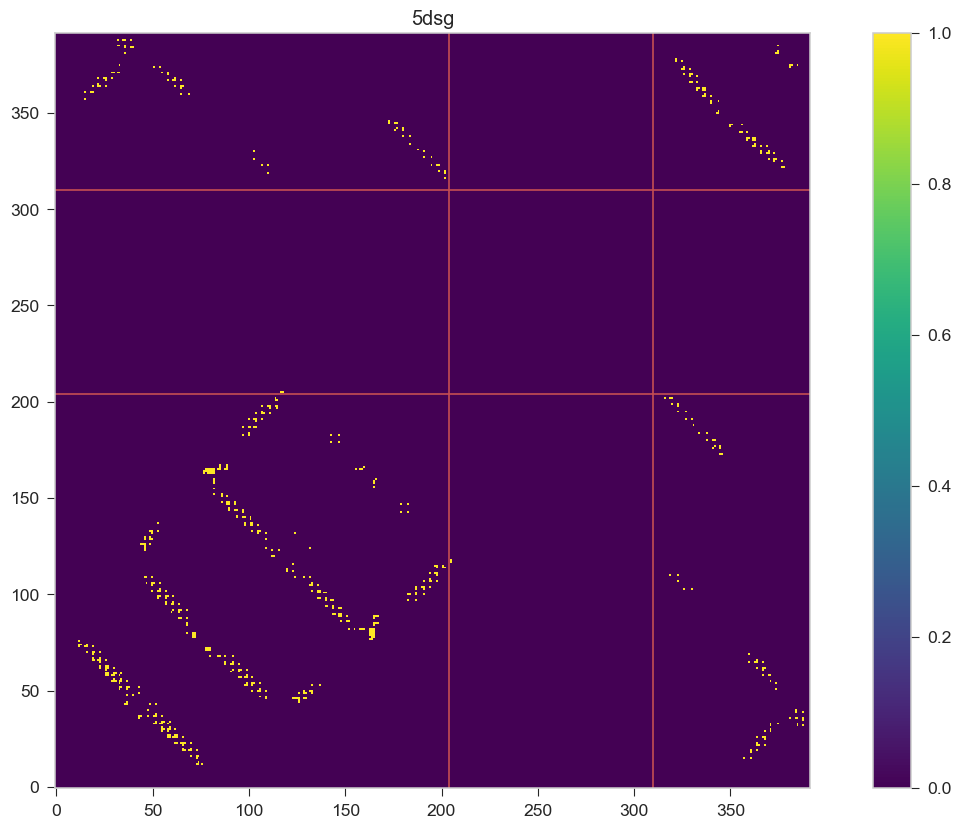

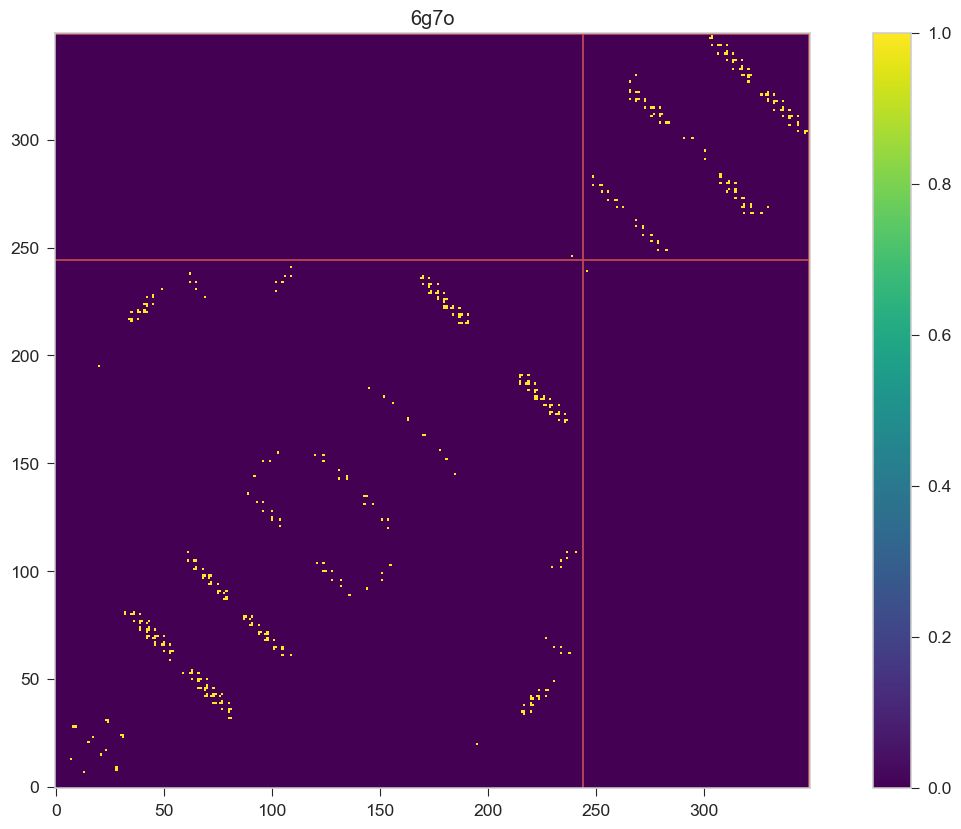

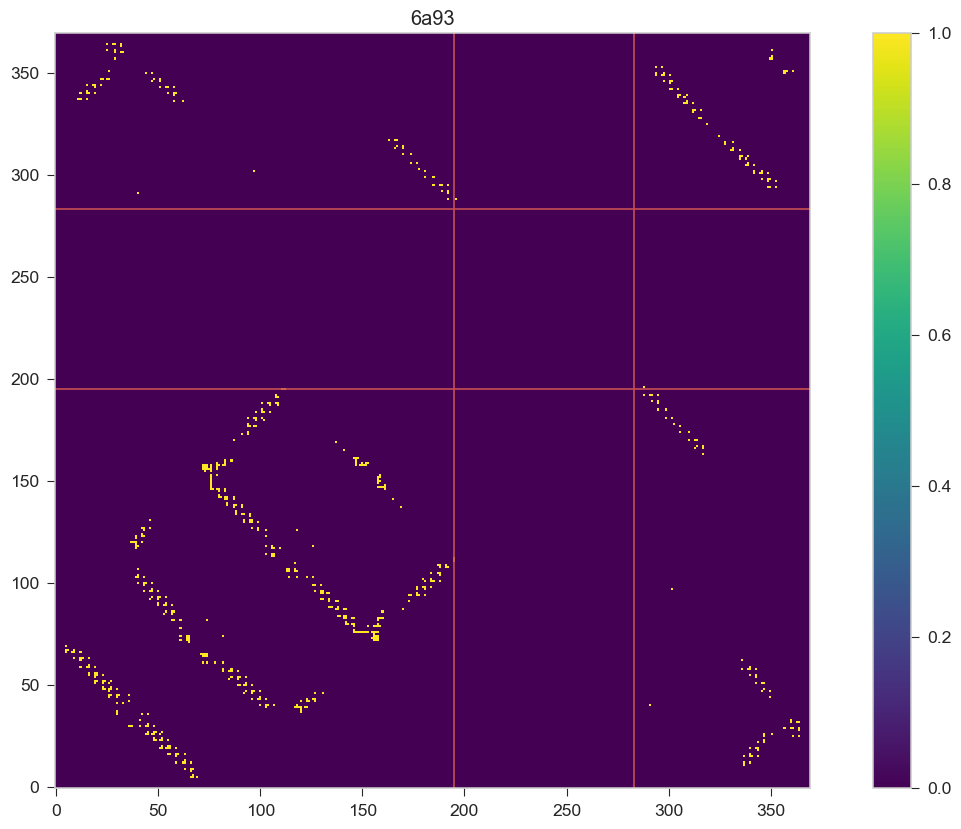

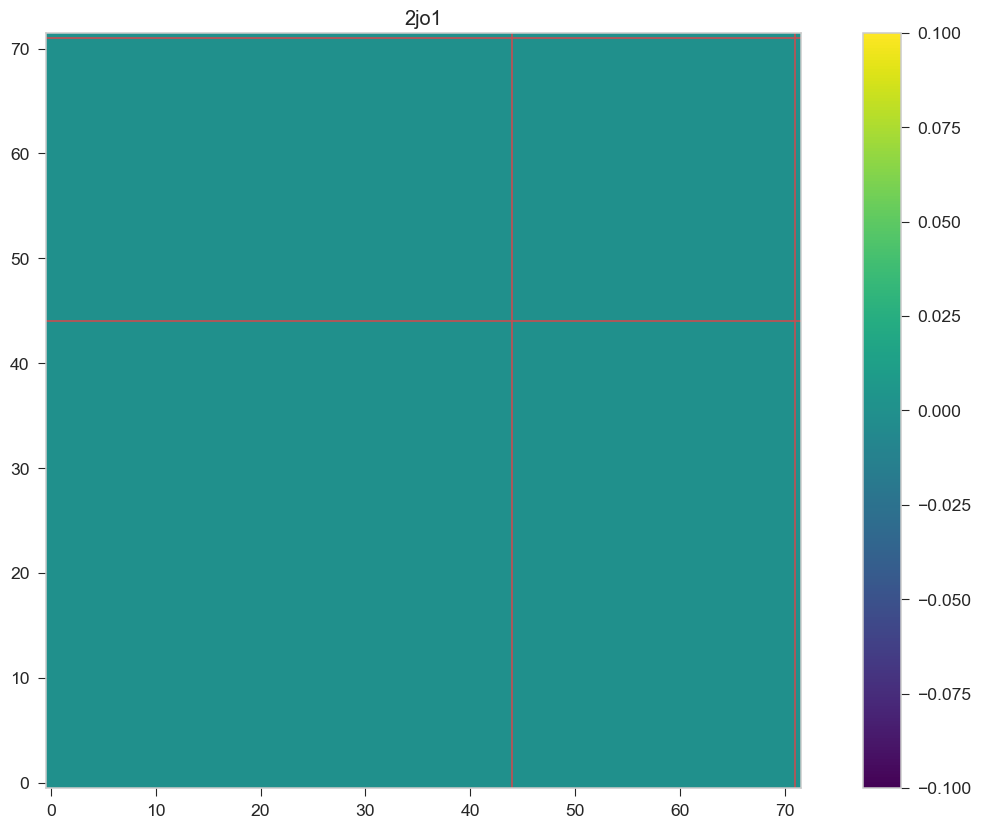

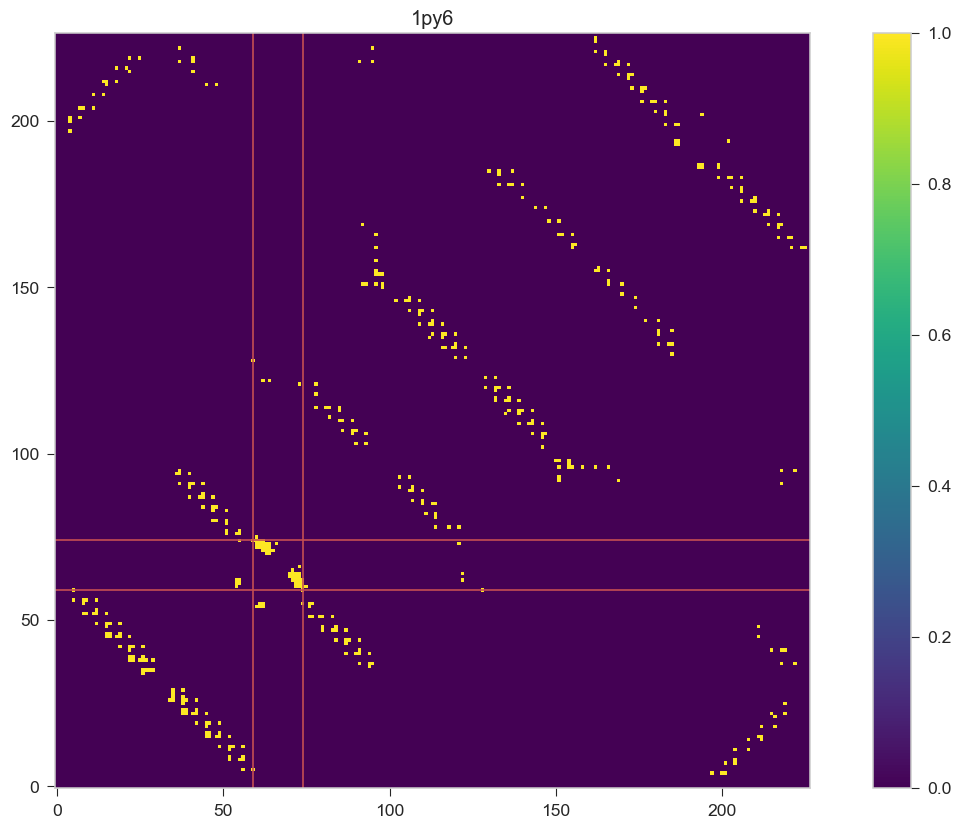

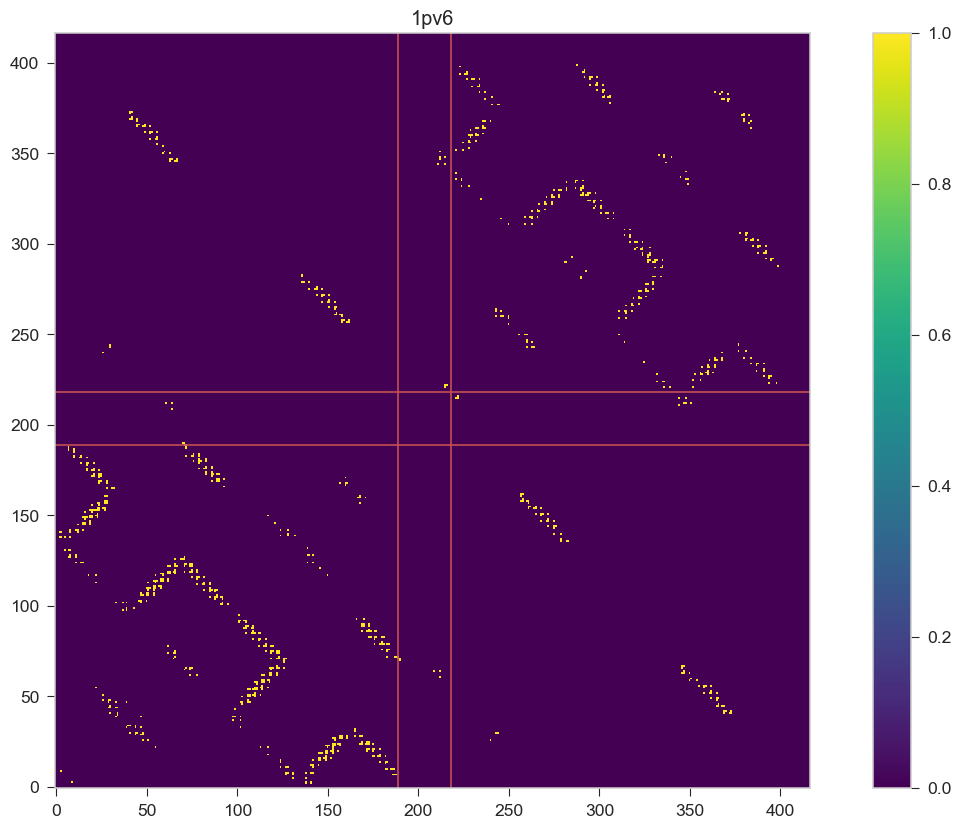

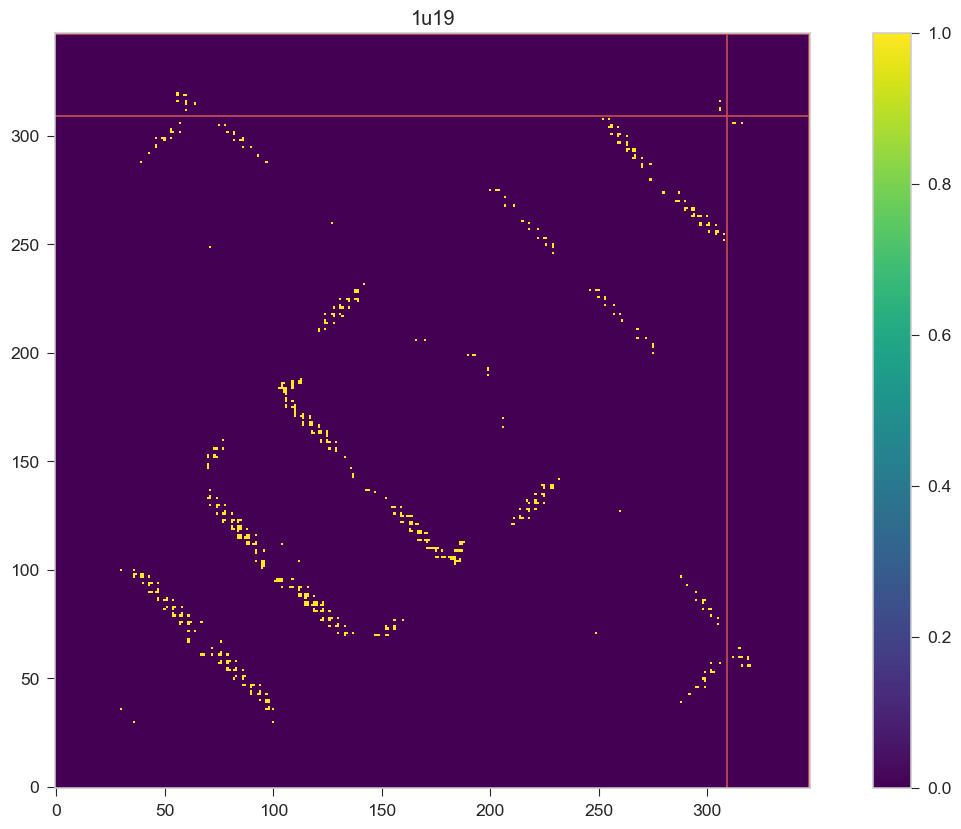

<Figure size 1618.03x1000 with 0 Axes>

In [12]:
for i, row in part_info.iterrows():
    pdb = row["Protein"]
    glob_start, glob_end = row["Range"].split("-")
    length = row["Length"]
    glob_start = int(glob_start)
    glob_end = int(glob_end)
    print(pdb, glob_start, glob_end)
    GlobularPart = list(range(glob_start, glob_end+1))
    MembranePart = []
    for i in range(1, length+1):
        if i not in GlobularPart:
            MembranePart.append(i)
    t = getContactMap(pdb)
    plt.imshow((t>0.5).astype(float), origin="bottom")
    plt.colorbar()
    plt.axhline(y=GlobularPart[0]-1, color='r', linestyle='-')
    plt.axhline(y=GlobularPart[-1]-1, color='r', linestyle='-')
    plt.axvline(x=GlobularPart[0]-1, color='r', linestyle='-')
    plt.axvline(x=GlobularPart[-1]-1, color='r', linestyle='-')
    plt.title(pdb)
    plt.savefig(f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/contact_maps/{pdb}_raptor.png")
    plt.figure()

In [15]:
print(pdb)

1u19


In [16]:
for i, row in part_info.iterrows():
    pdb = row["Protein"]
    t = getContactMap(pdb)
    np.save(f"/Users/weilu/Research/raptorX/{pdb}/{pdb}.npy", t)

In [ ]:
for i, row in part_info.iterrows():
    pdb = row["Protein"]
    glob_start, glob_end = row["Range"].split("-")
    length = row["Length"]
    glob_start = int(glob_start)
    glob_end = int(glob_end)
    print(pdb, glob_start, glob_end)
    GlobularPart = list(range(glob_start, glob_end+1))
    MembranePart = []
    for i in range(1, length+1):
        if i not in GlobularPart:
            MembranePart.append(i)
    t = getContactMap(pdb)

In [204]:
cmd = '''\
load ../cleaned_pdbs/{0}.pdb
select globular_{0}, i. {1}-{2} and model {0}
color red, globular_{0}
'''
for i, row in part_info.iterrows():
    pdb = row["Protein"]
    glob_start, glob_end = row["Range"].split("-")
    length = row["Length"]
    glob_start = int(glob_start)
    glob_end = int(glob_end)
    print(pdb, glob_start, glob_end)
    GlobularPart = list(range(glob_start, glob_end+1))
    MembranePart = []
    for i in range(1, length+1):
        if i not in GlobularPart:
            MembranePart.append(i)
    with open(f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/color_parts_eye/{pdb}.pml", "w") as f:
        cmd_out = cmd.format(pdb, GlobularPart[0], GlobularPart[-1])
        f.write(cmd_out)

2xov_complete 1 63
6e67A 201 380
5xpd 222 269
3kp9 165 259
4a2n 101 125
5d91 1 131
4nv6 167 258
4p79 31 61
5dsg 205 311
6g7o 245 350
6a93 196 284
2jo1 45 72
1py6 60 75
1pv6 190 219
1u19 310 348


In [175]:
part_info.Range.str.split("-")

0    [310, 348]
1    [190, 219]
2      [65, 77]
3      [31, 61]
4    [167, 258]
5      [1, 131]
6    [101, 125]
7    [222, 269]
Name: Range, dtype: object

In [200]:
cmd = '''\
load ../cleaned_pdbs/{0}.pdb
select globular_{0}, i. {1}-{2} and model {0}
color red, globular
'''
for a in d_:
    pdb, t, MembranePart, GlobularPart = a
    print(pdb)
    with open(f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/color_parts_eye/{pdb}.pml", "w") as f:
        cmd_out = cmd.format(pdb, GlobularPart[0], GlobularPart[-1])
        f.write(cmd_out)

2xov_complete
6e67A
5xpd
3kp9
4a2n
5d91
4nv6
4p79
5dsg
6g7o
6a93
2jo1
1py6
1pv6
1u19


In [170]:
len(d_)

15

In [138]:
print(list(range(190, 219)))

[190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218]


In [ ]:
# def getContactMap(pdb):
#     fileLocation = f"/Users/weilu/Research/raptorX/{pdb}/contactmap.txt"
#     data = pd.read_csv(fileLocation, skiprows=6, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
#     data["i"] = data["i"].astype(int)
#     data["j"] = data["j"].astype(int)
#     n = int(info.query(f"Protein =='{pdb}'")["Length"])
#     t = np.zeros((n,n))
#     for index, d in data.iterrows():
#     #     print(index)
#         i = int(d["i"]) - 1
#         j = int(d["j"]) - 1 
#         p = d["p"]
#     #     print(i,j,p)
#         t[i,j] = p
#         t[j,i] = p
#     topFile = f"/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation/TM_pred/{pdb}_topo"
#     MembranePart, GlobularPart = get_two_part_from_prediction(topFile)
#     return t, MembranePart, GlobularPart

2xov_complete 276
6e67A 457
5xpd 269
3kp9 259
4a2n 192
5d91 335
4nv6 264
4p79 181
5dsg 392
6g7o 350
6a93 370
2jo1 72
1py6 227
1pv6 417
1u19 348


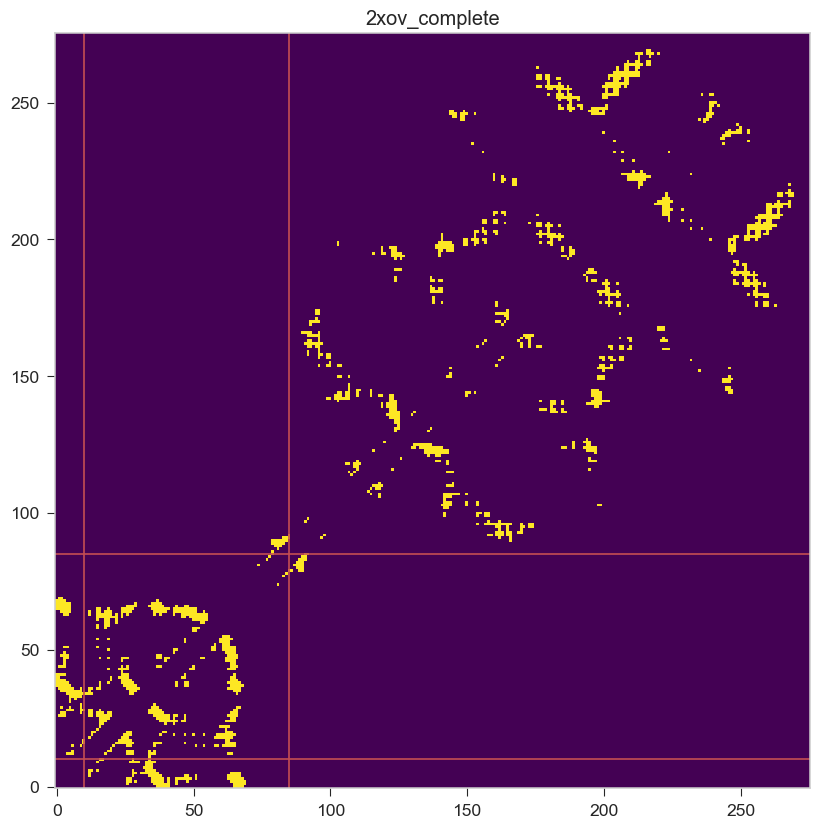

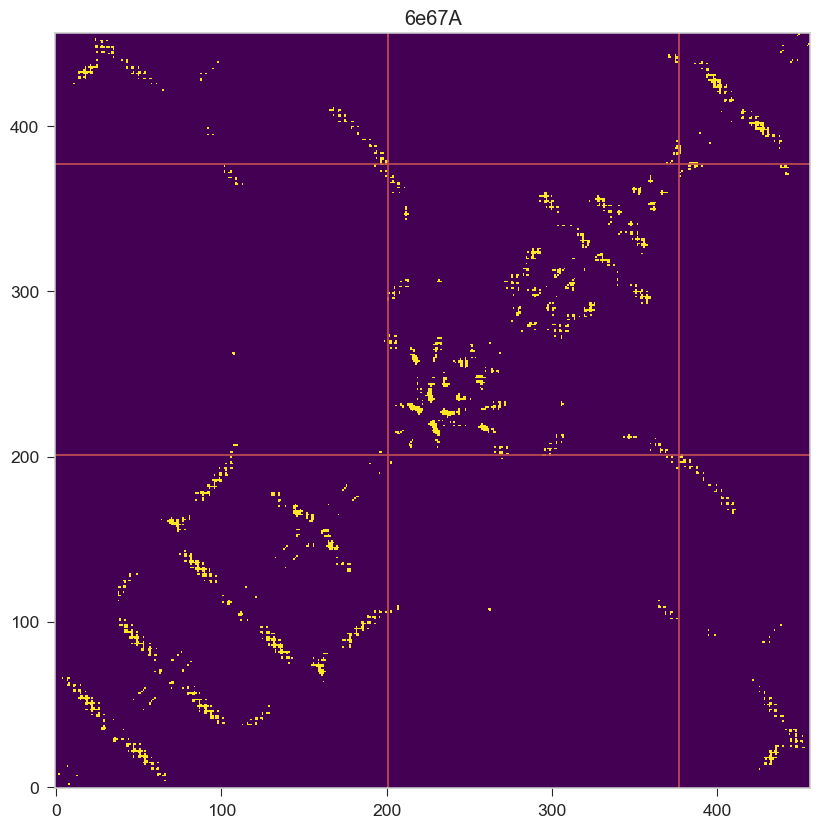

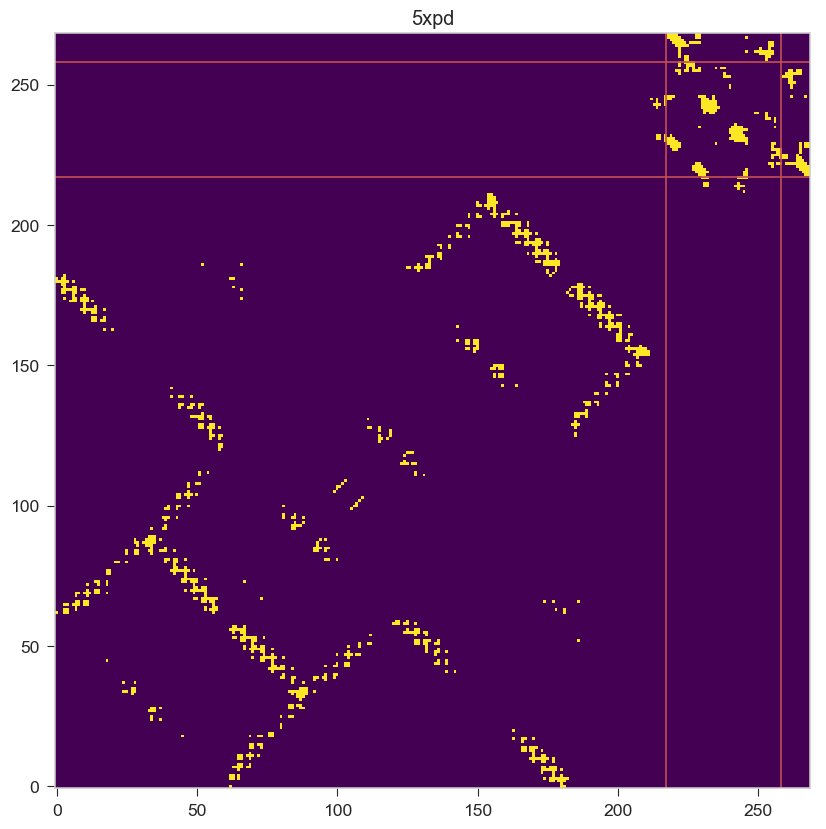

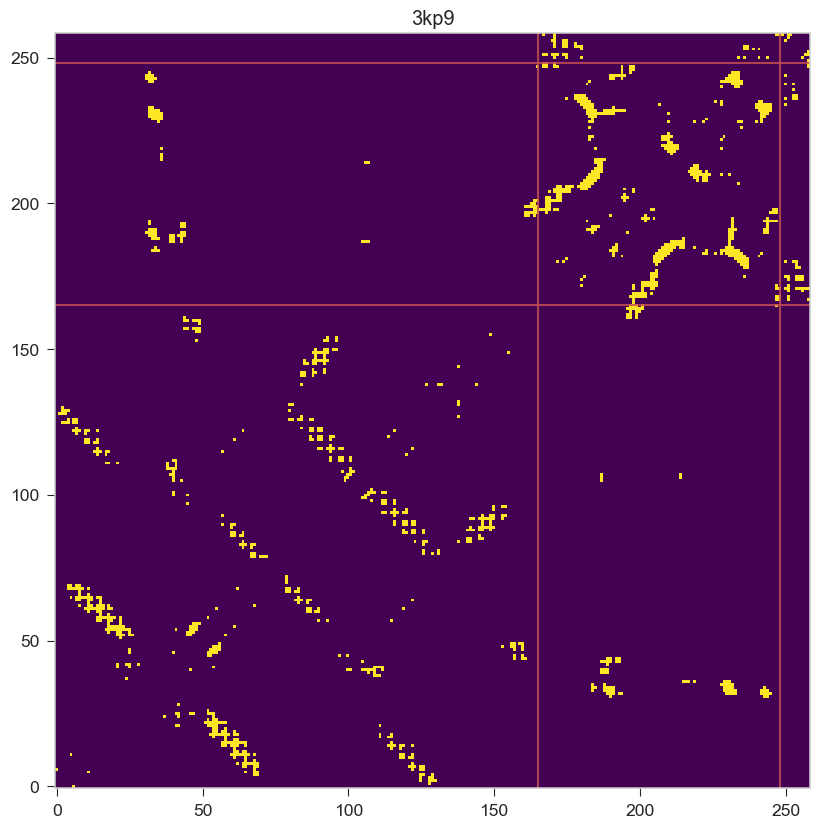

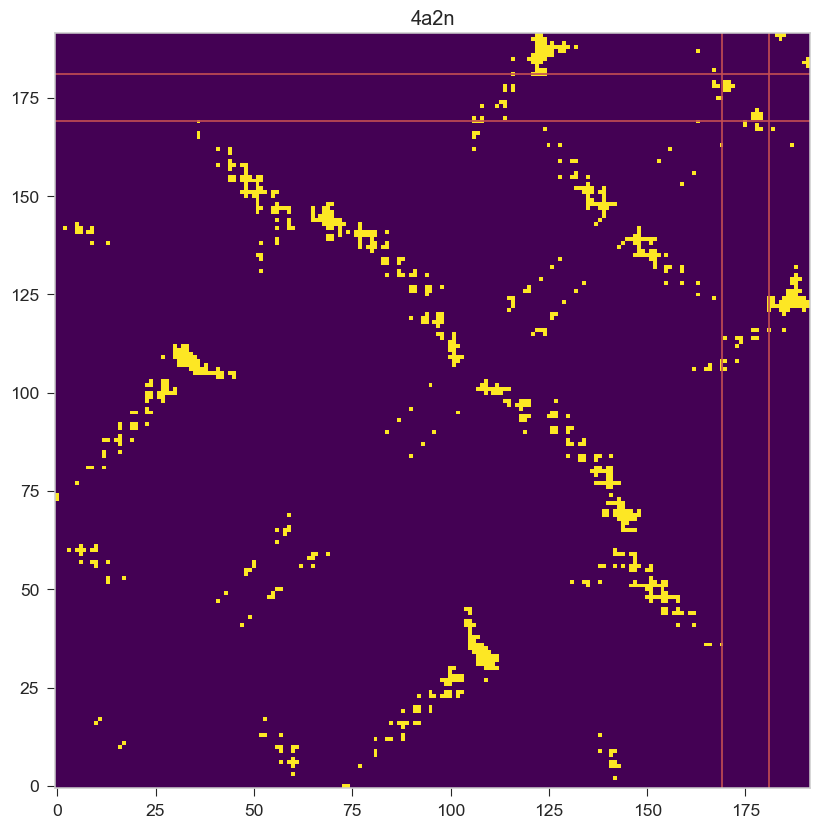

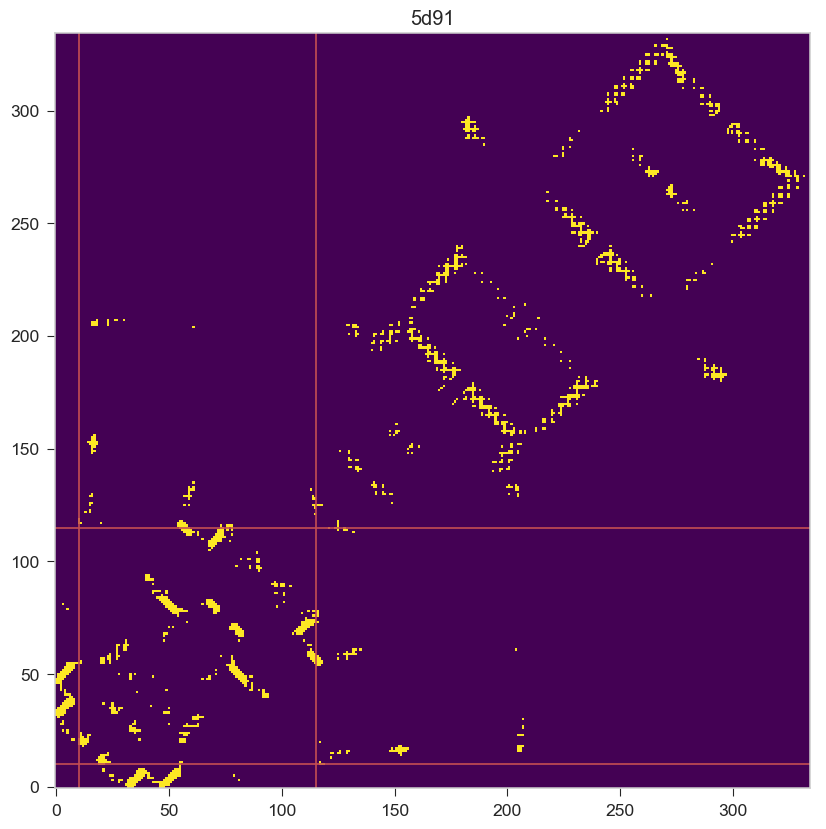

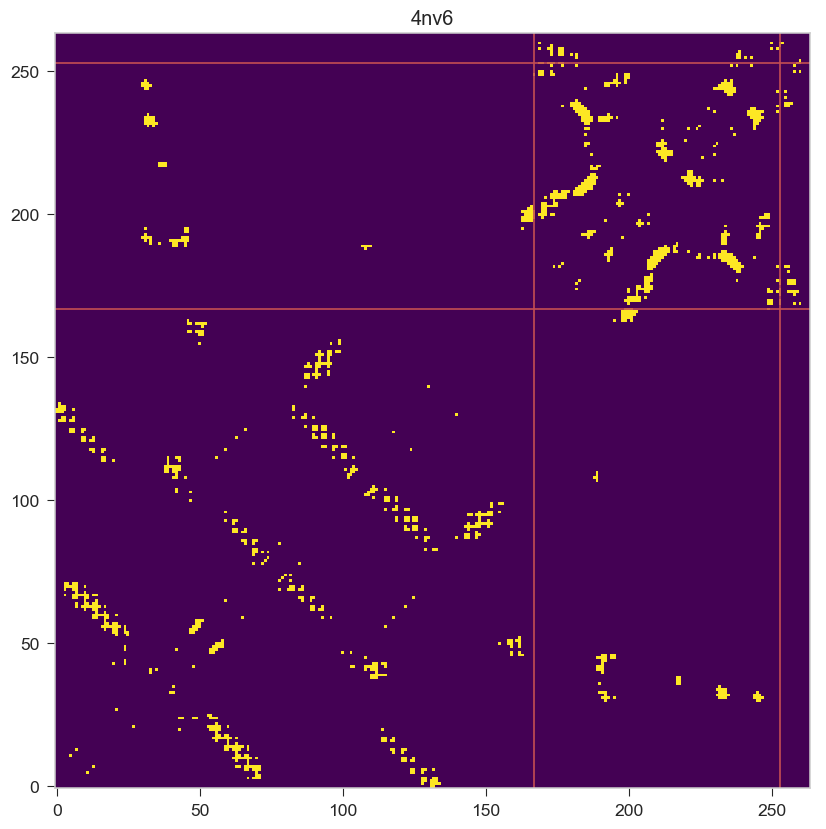

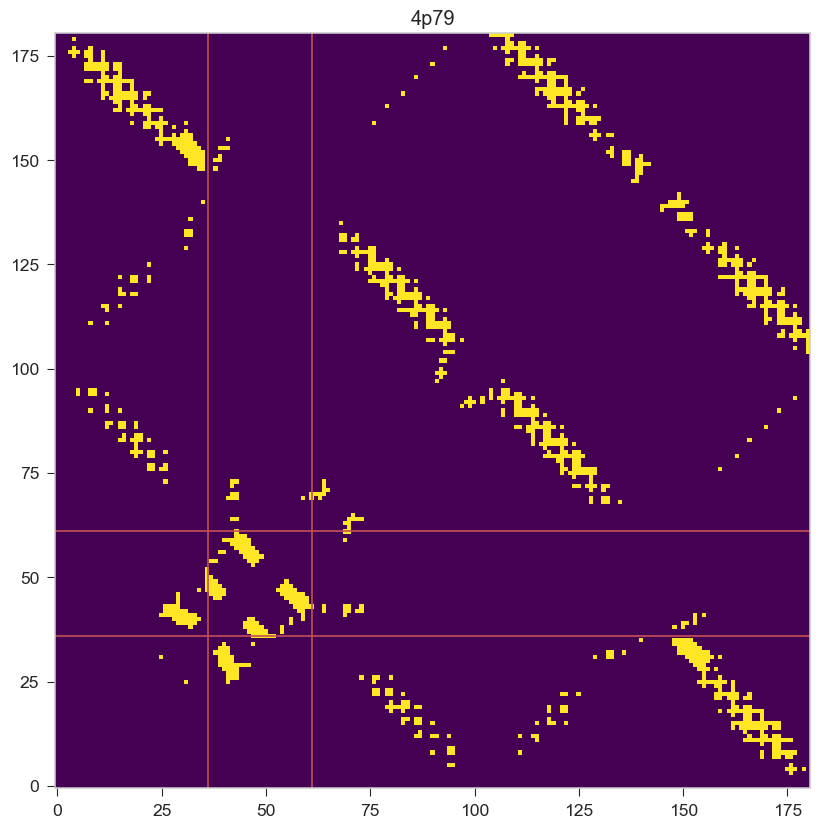

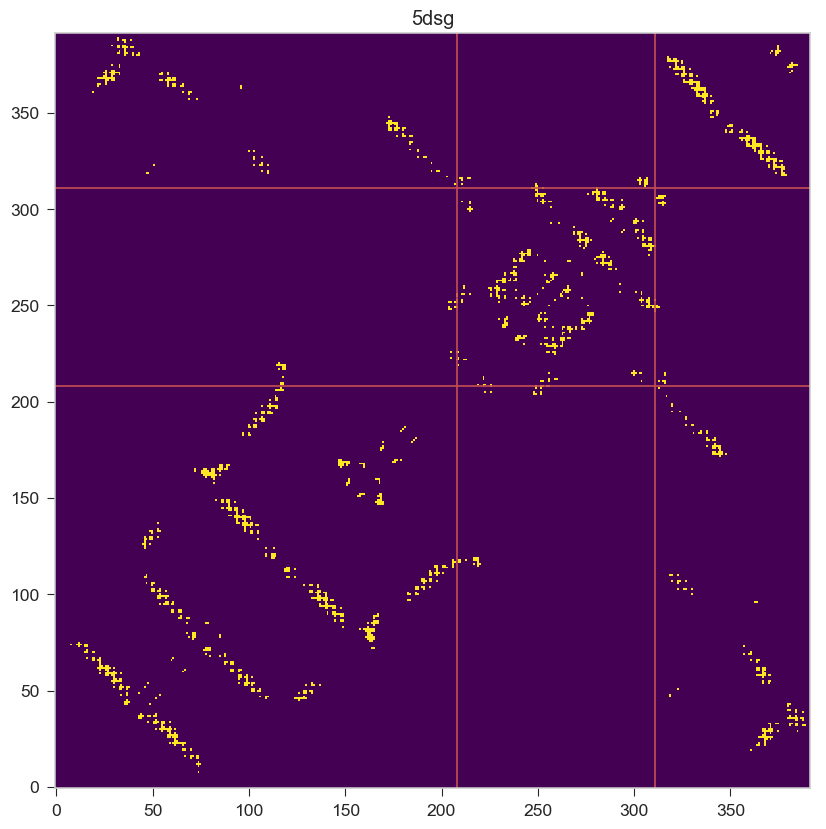

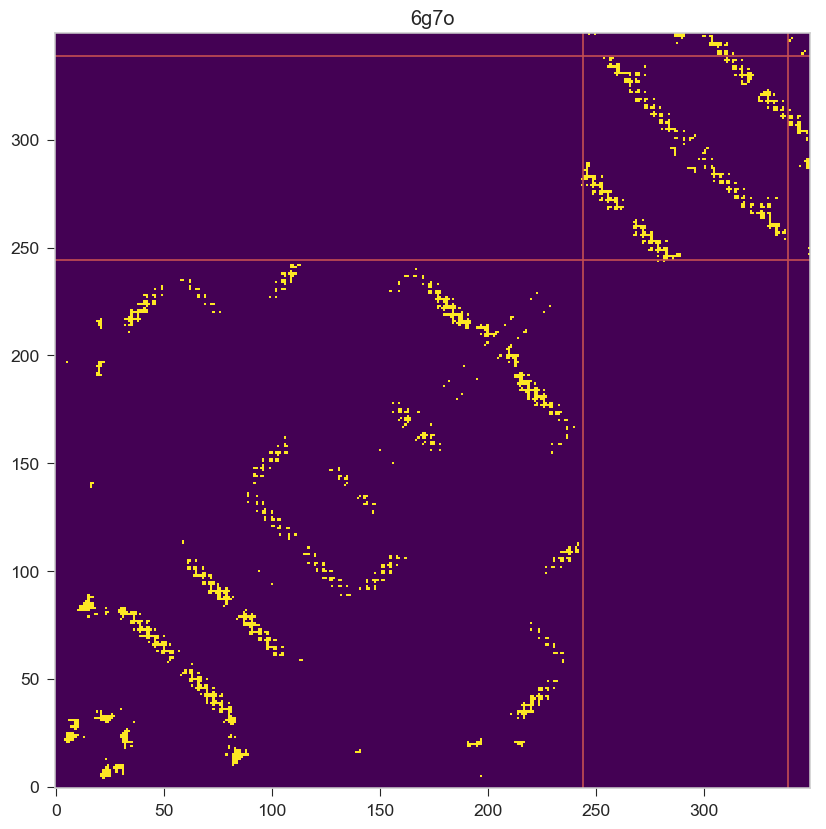

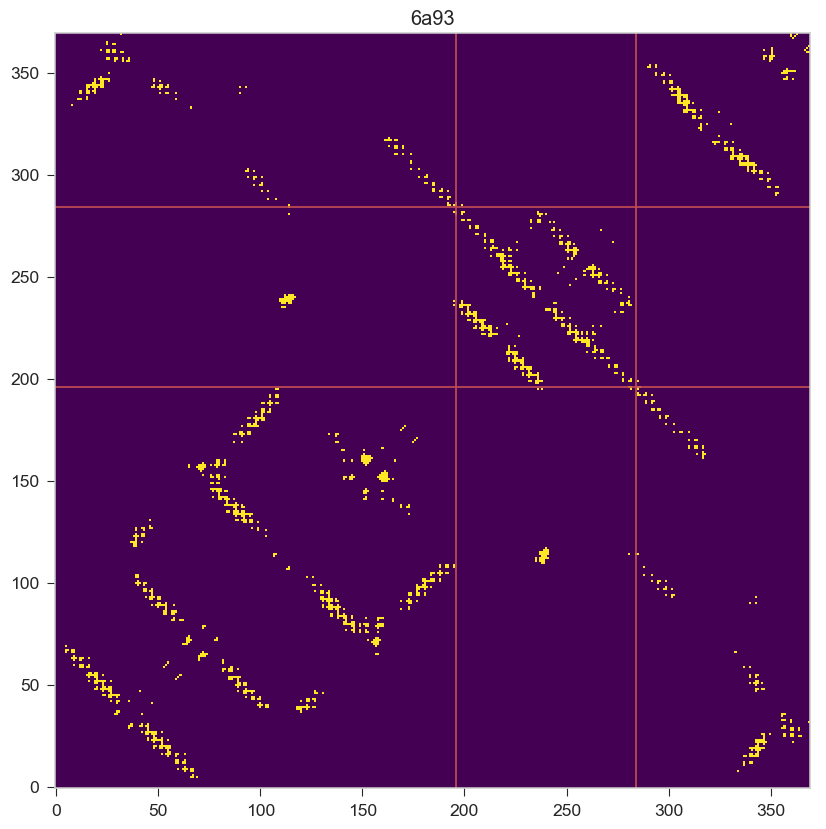

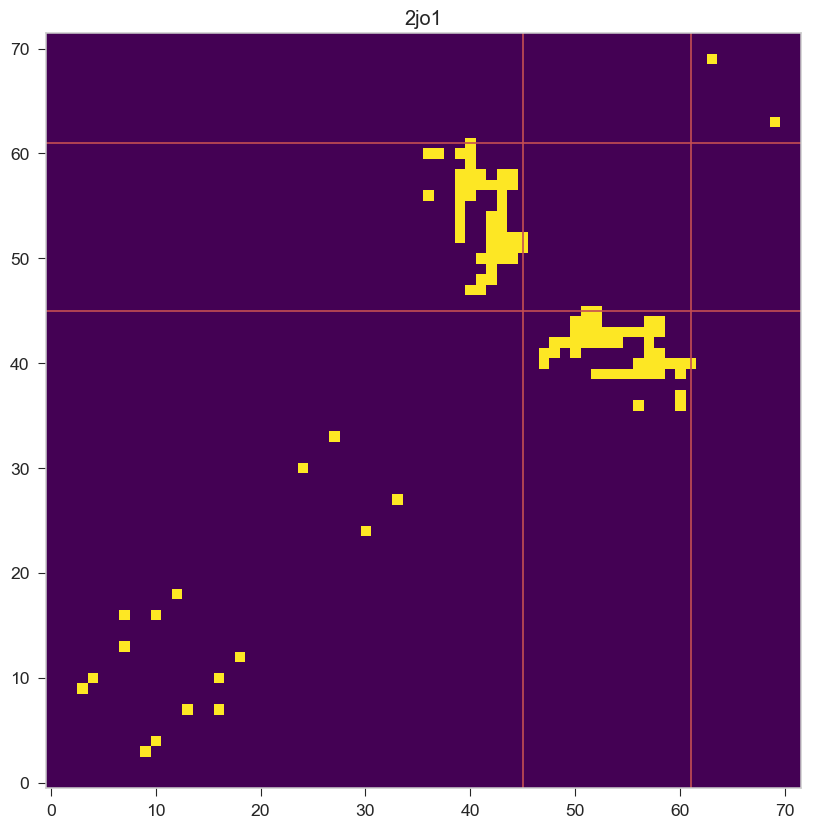

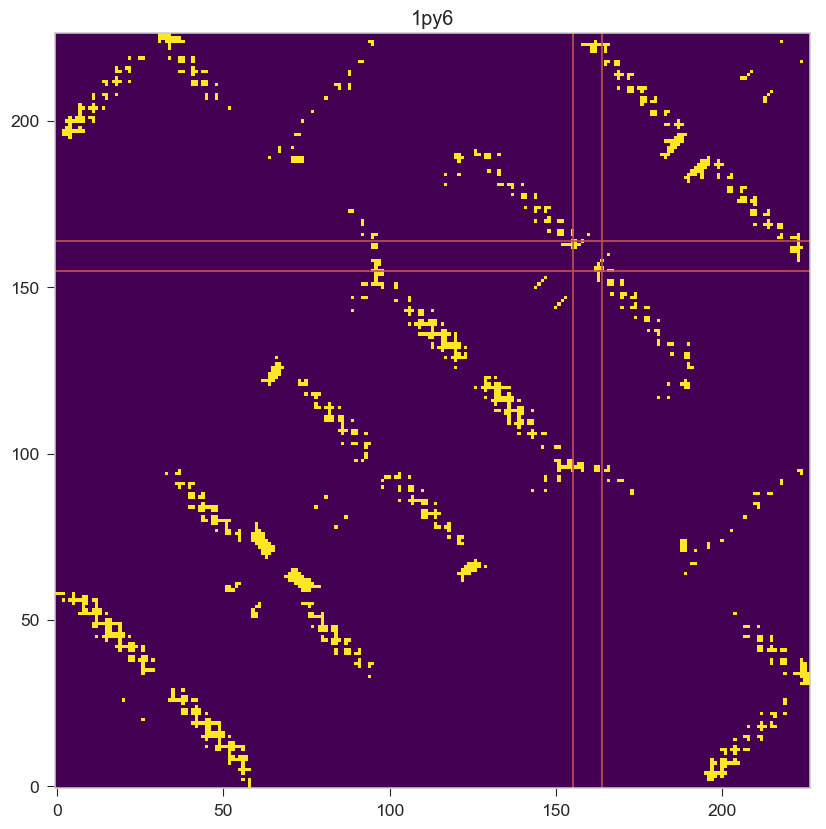

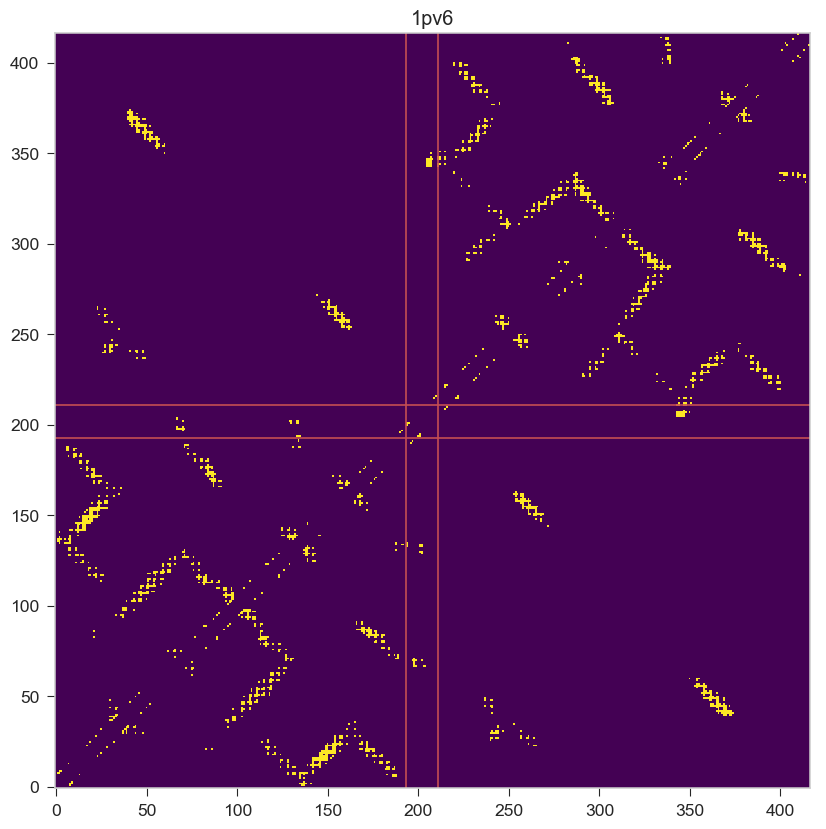

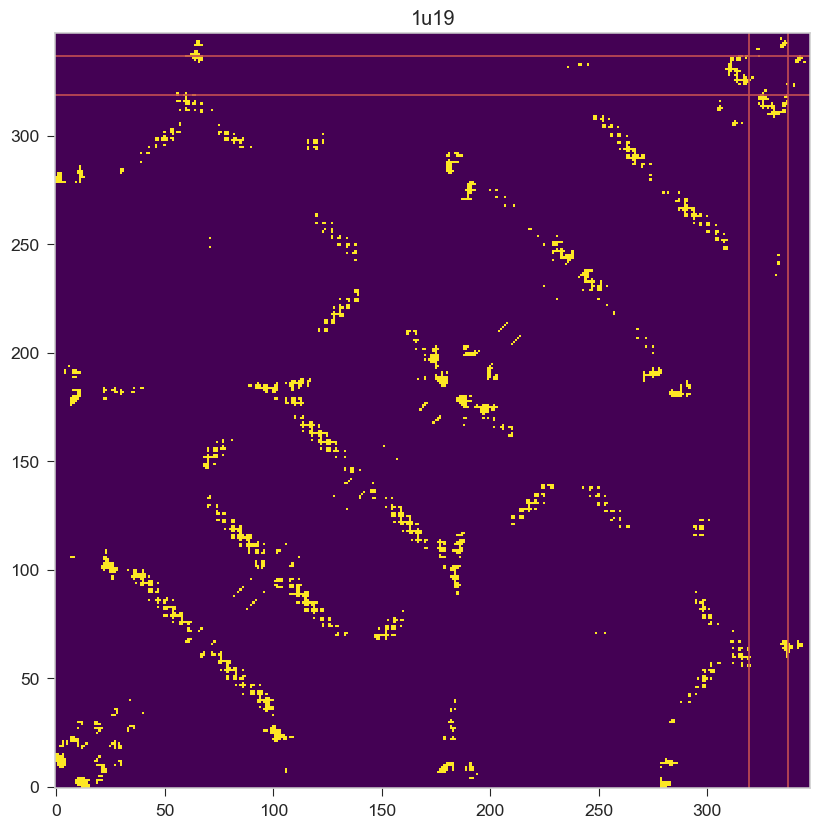

<Figure size 1618.03x1000 with 0 Axes>

In [168]:
# for a in d_:
#     pdb, t, MembranePart, GlobularPart = a
#     fileLocation = f"/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation/cleaned_pdbs/{pdb}.pdb"
#     data = getContactMapFromPDB(fileLocation)
#     plt.imshow(data, origin="bottom")
# #     plt.colorbar()
#     plt.axhline(y=GlobularPart[0], color='r', linestyle='-')
#     plt.axhline(y=GlobularPart[-1], color='r', linestyle='-')
#     plt.axvline(x=GlobularPart[0], color='r', linestyle='-')
#     plt.axvline(x=GlobularPart[-1], color='r', linestyle='-')
#     plt.title(pdb)
#     plt.savefig(f"/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation/contact_maps/{pdb}.png")
#     plt.figure()

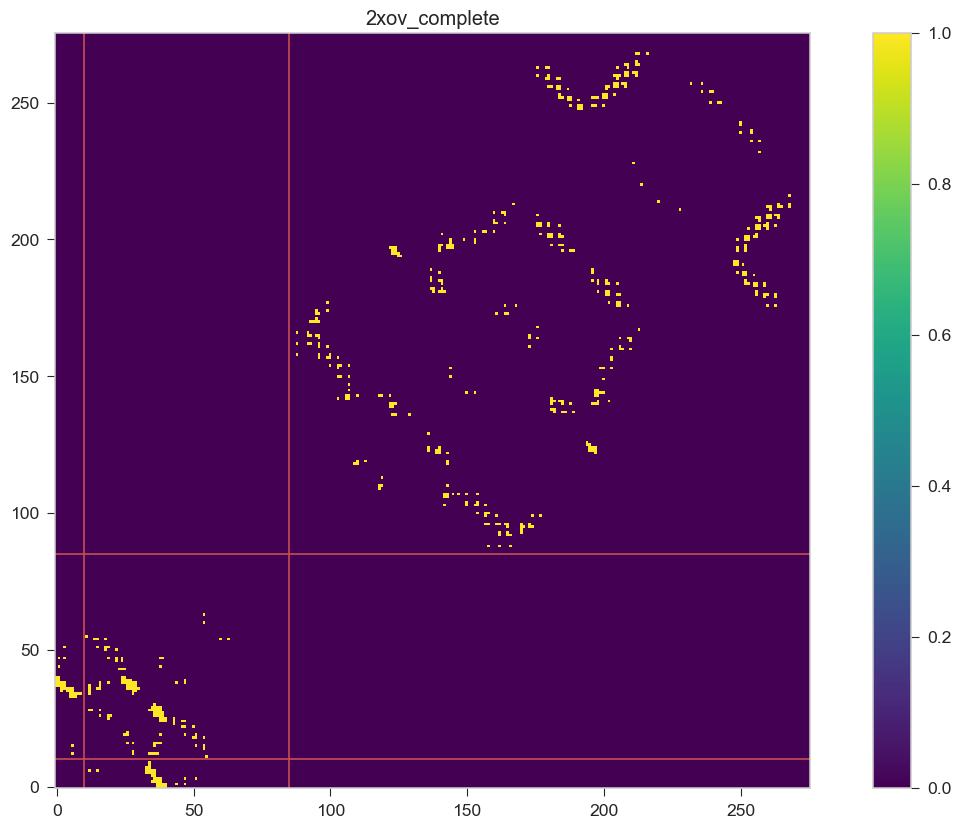

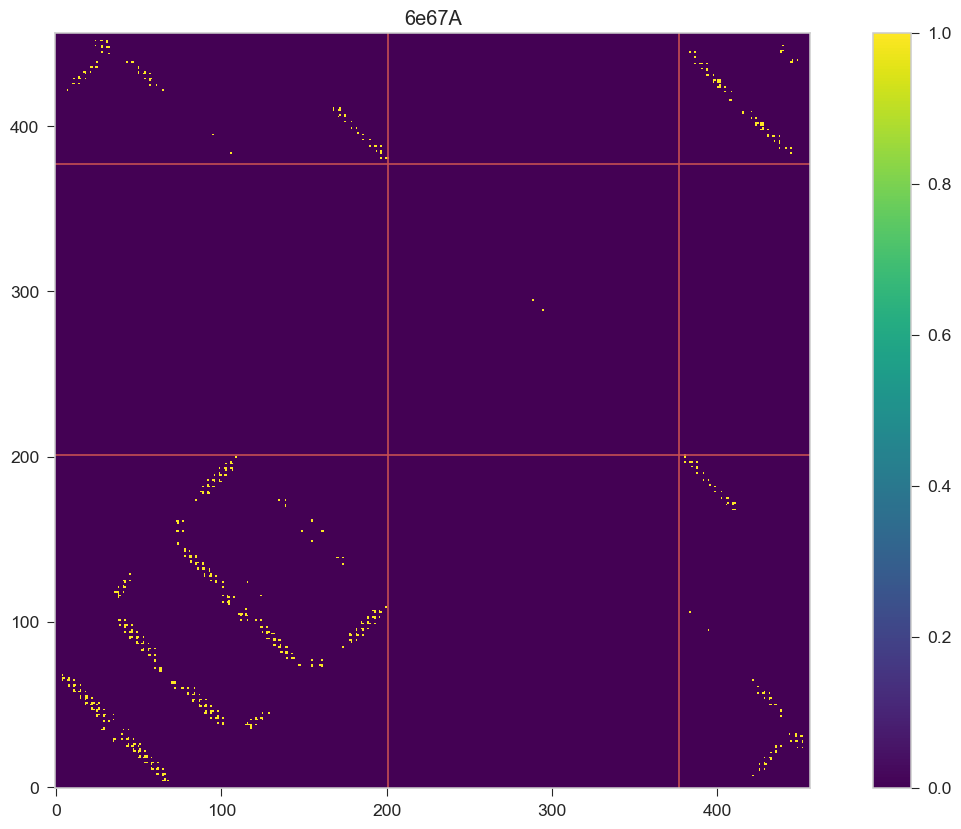

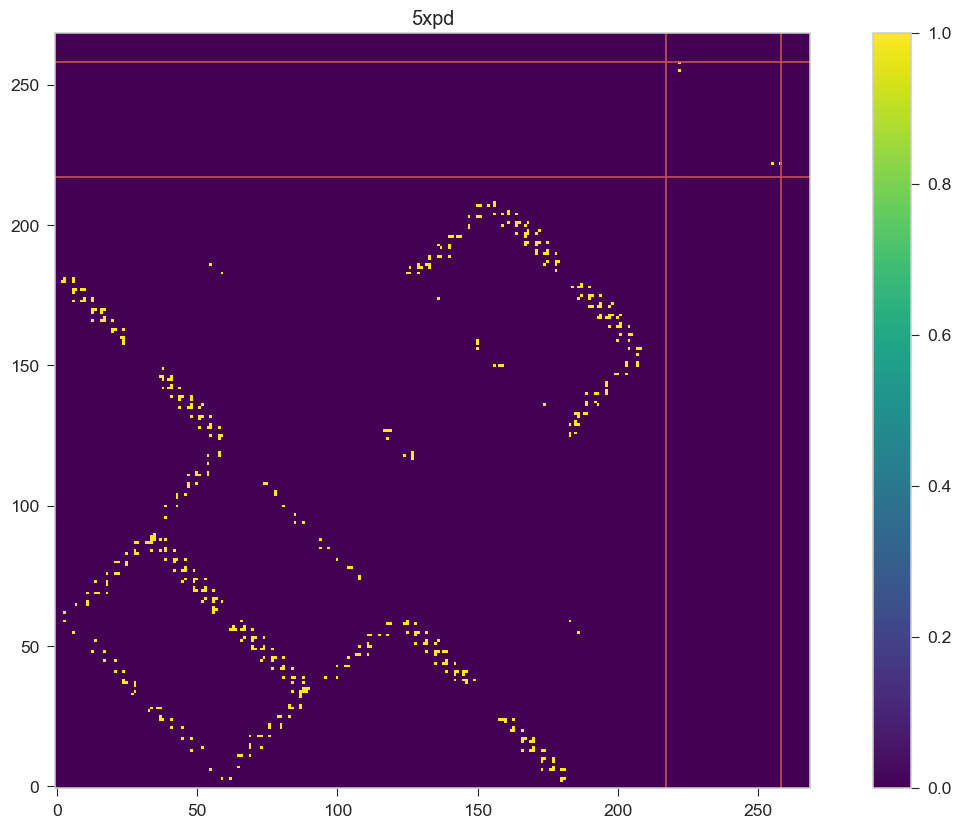

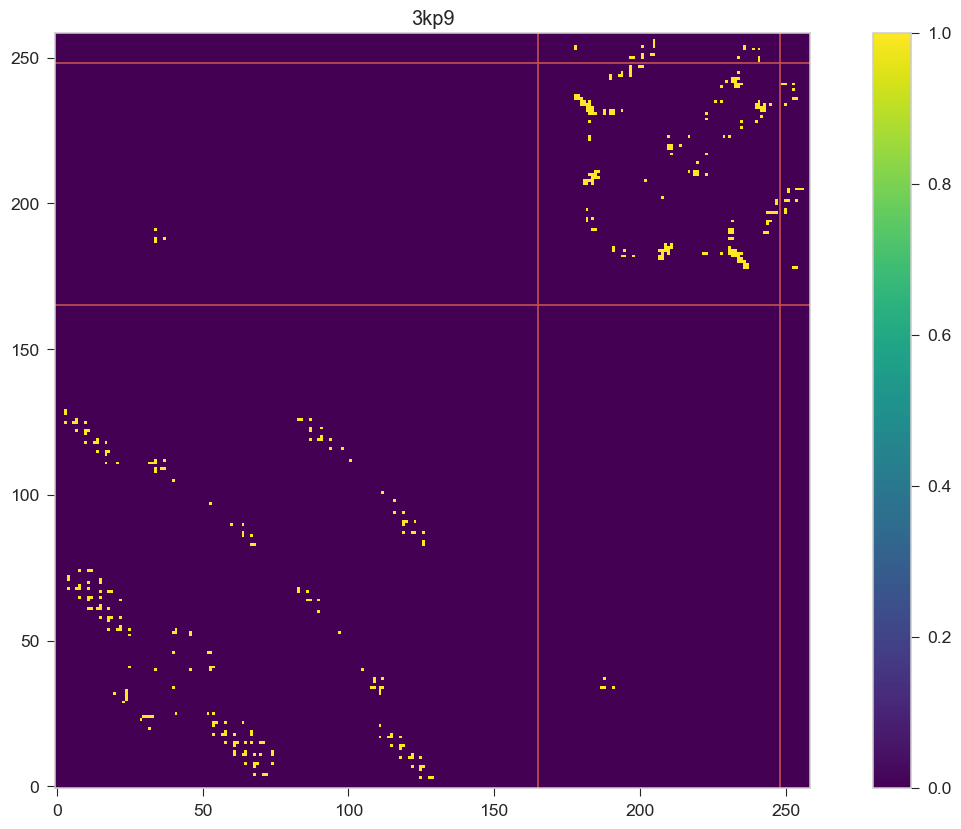

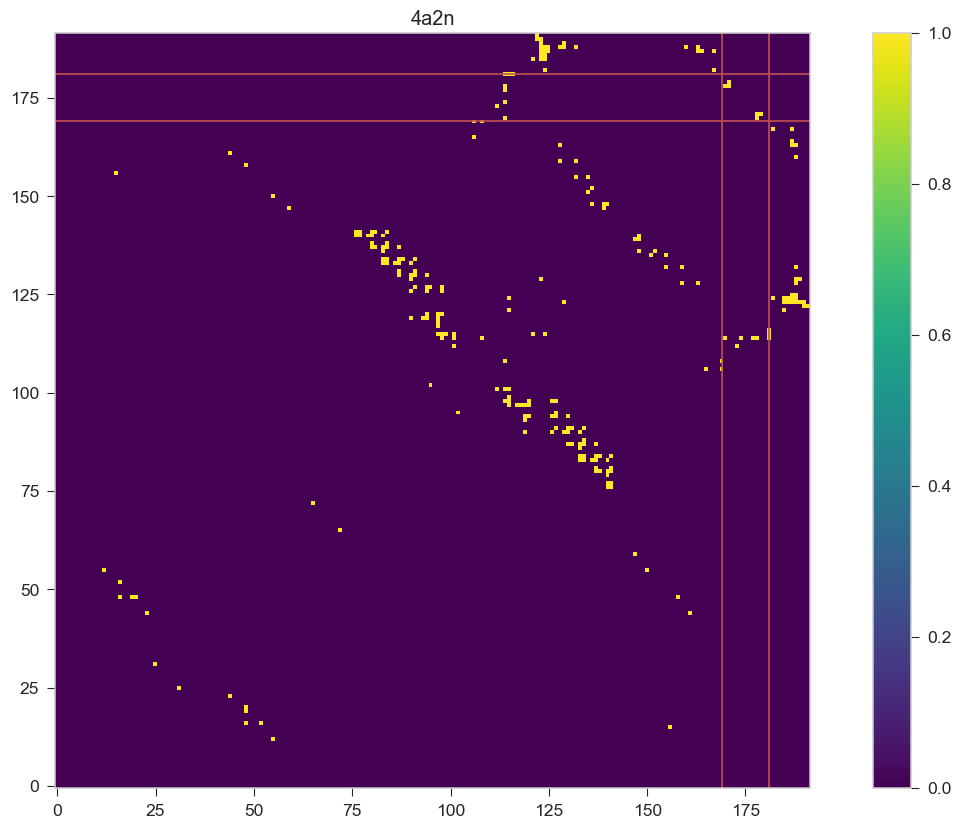

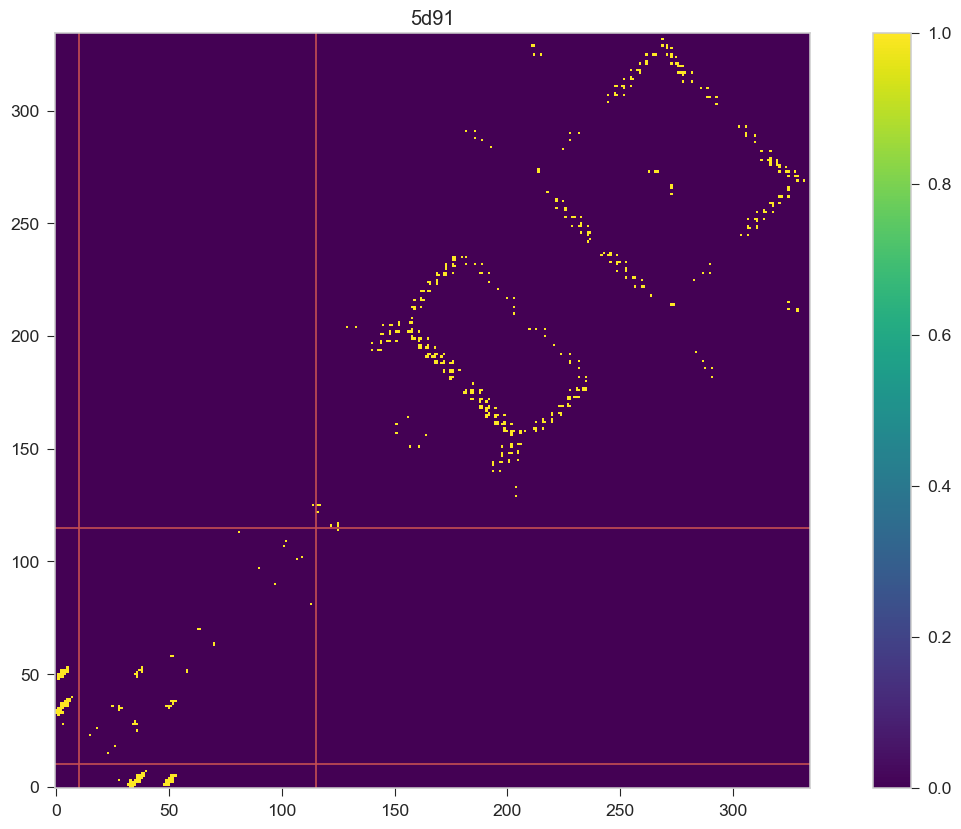

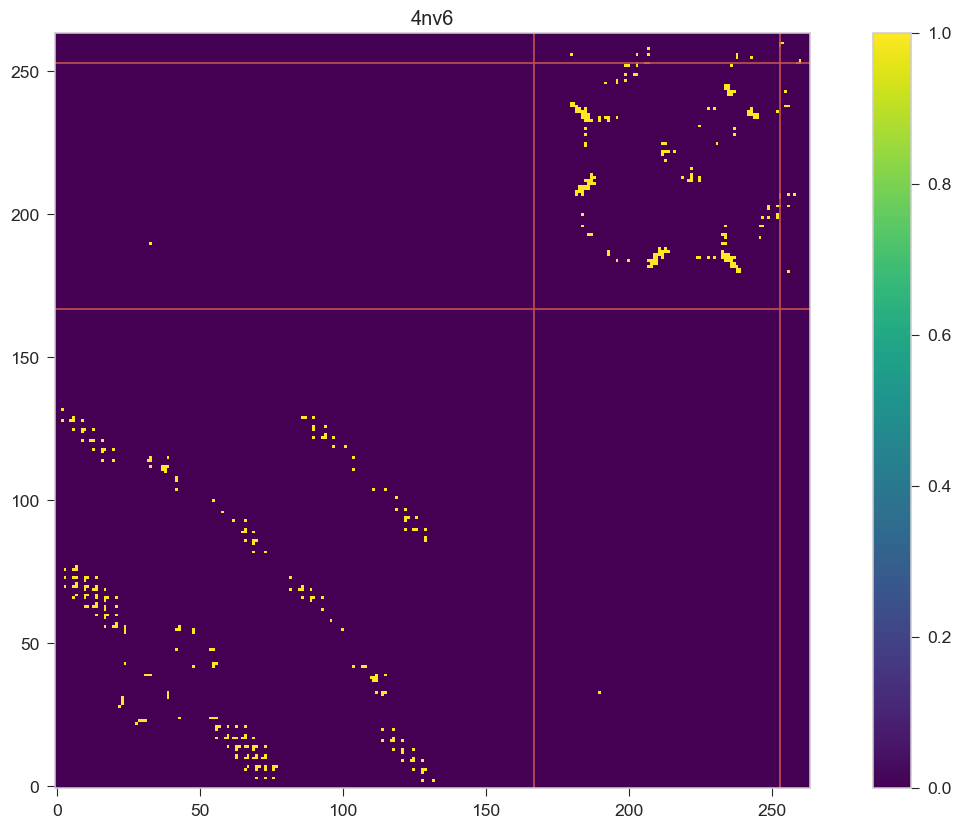

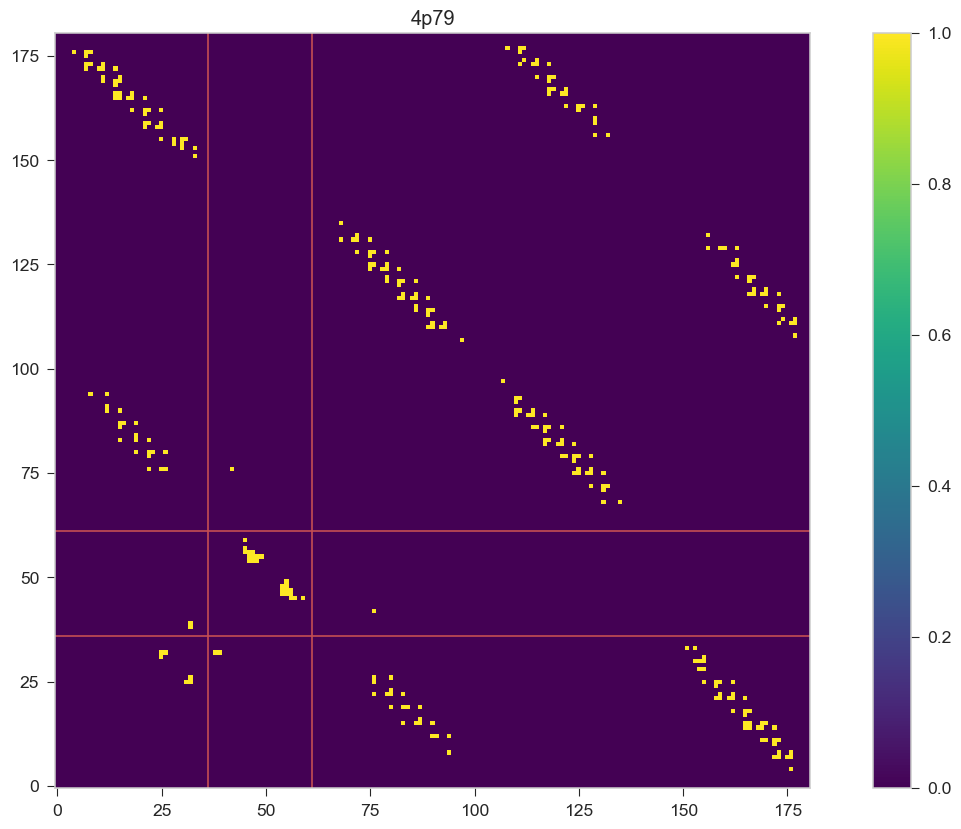

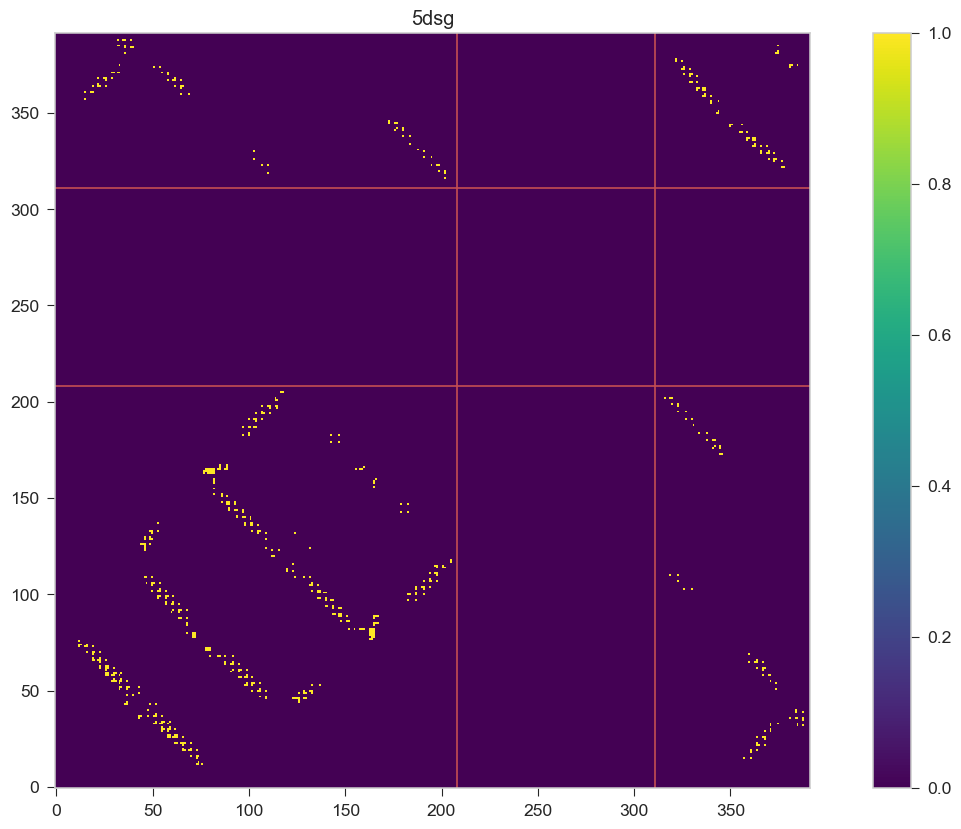

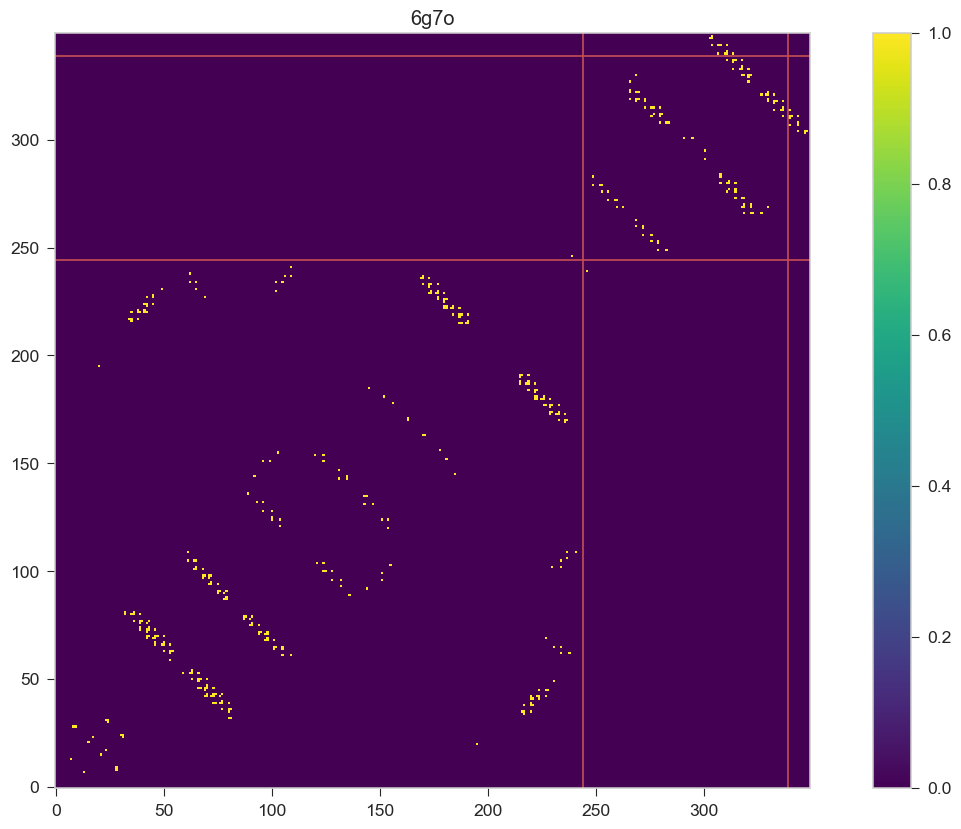

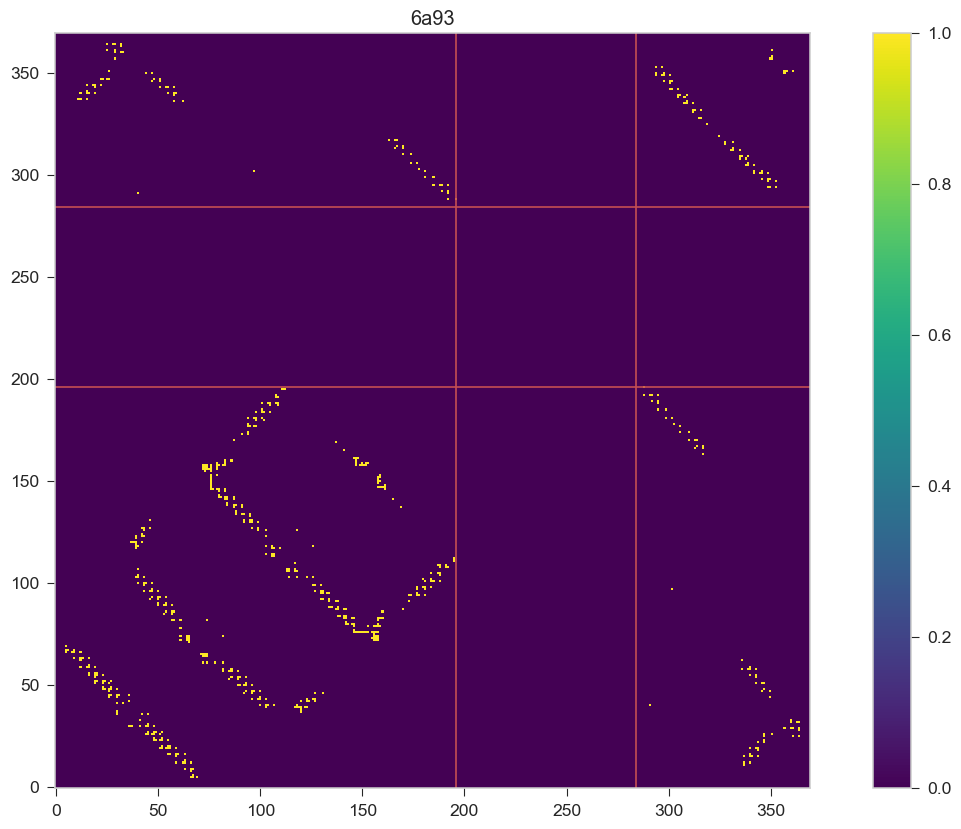

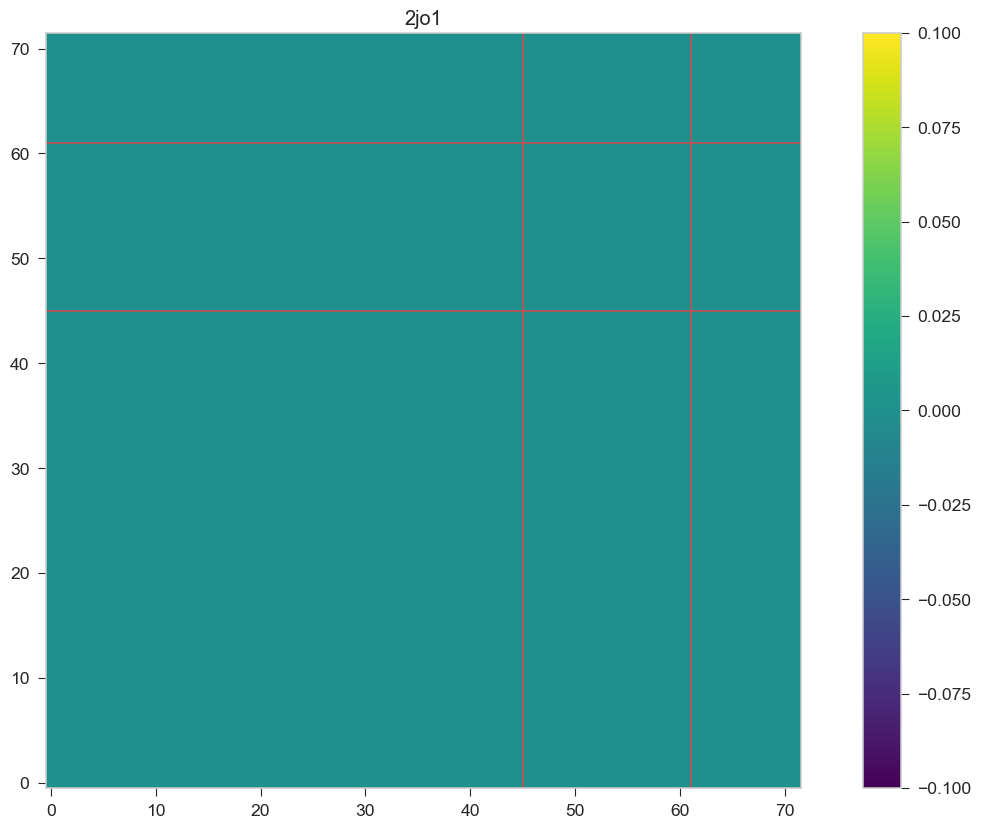

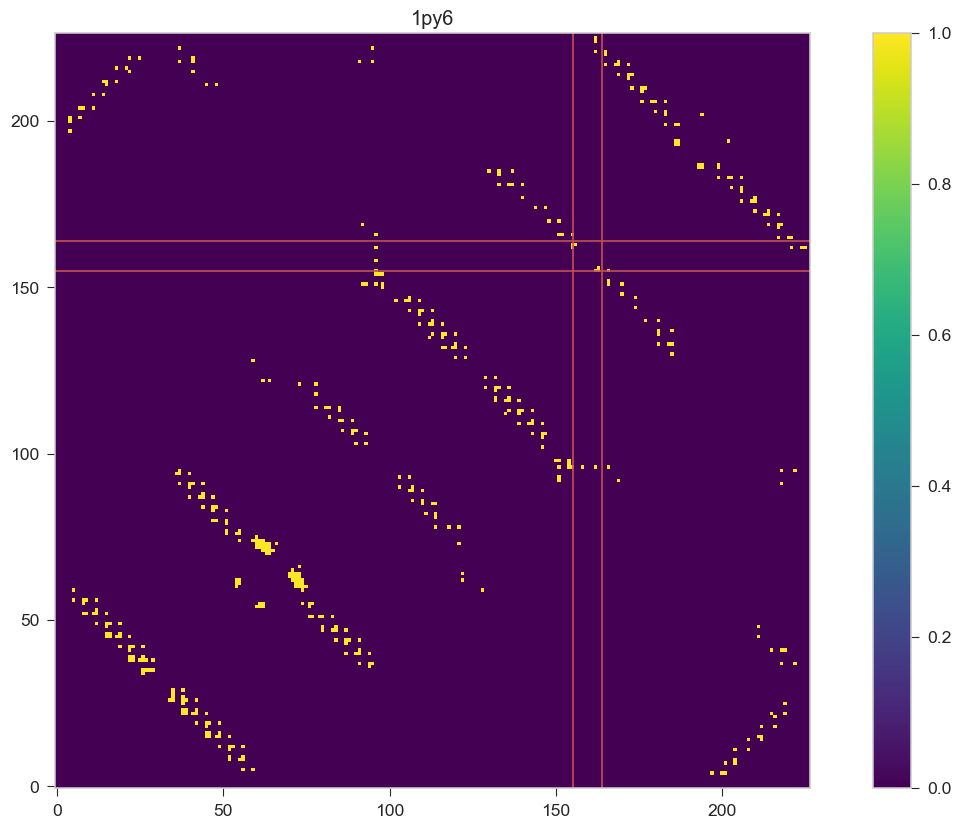

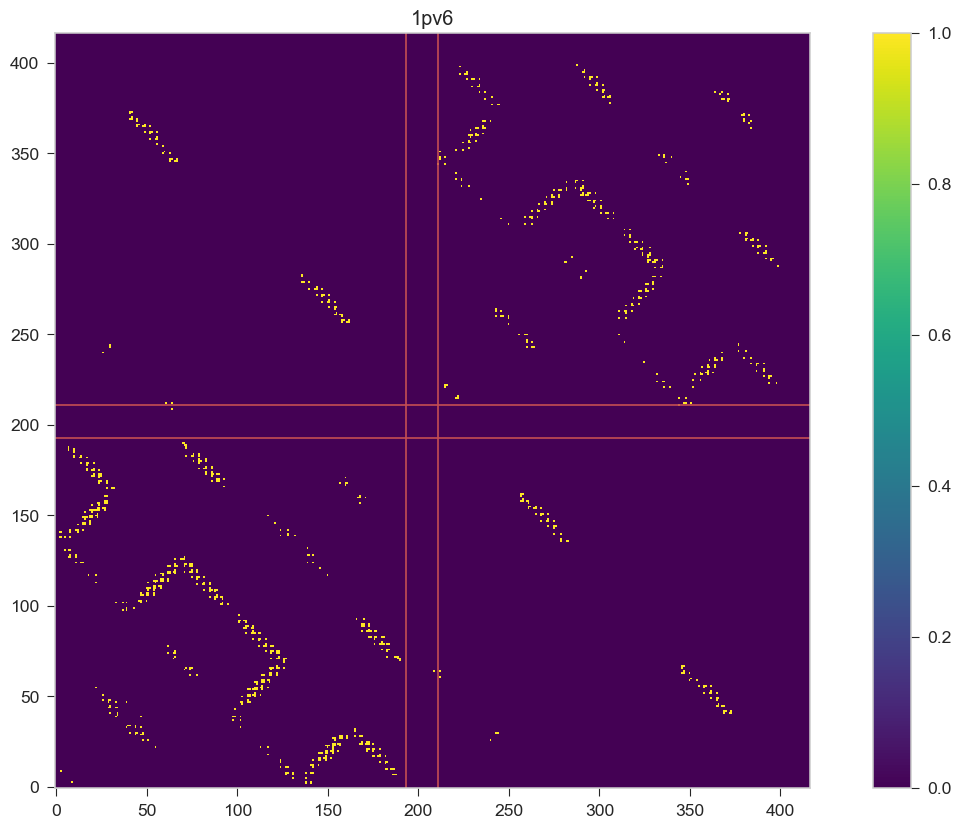

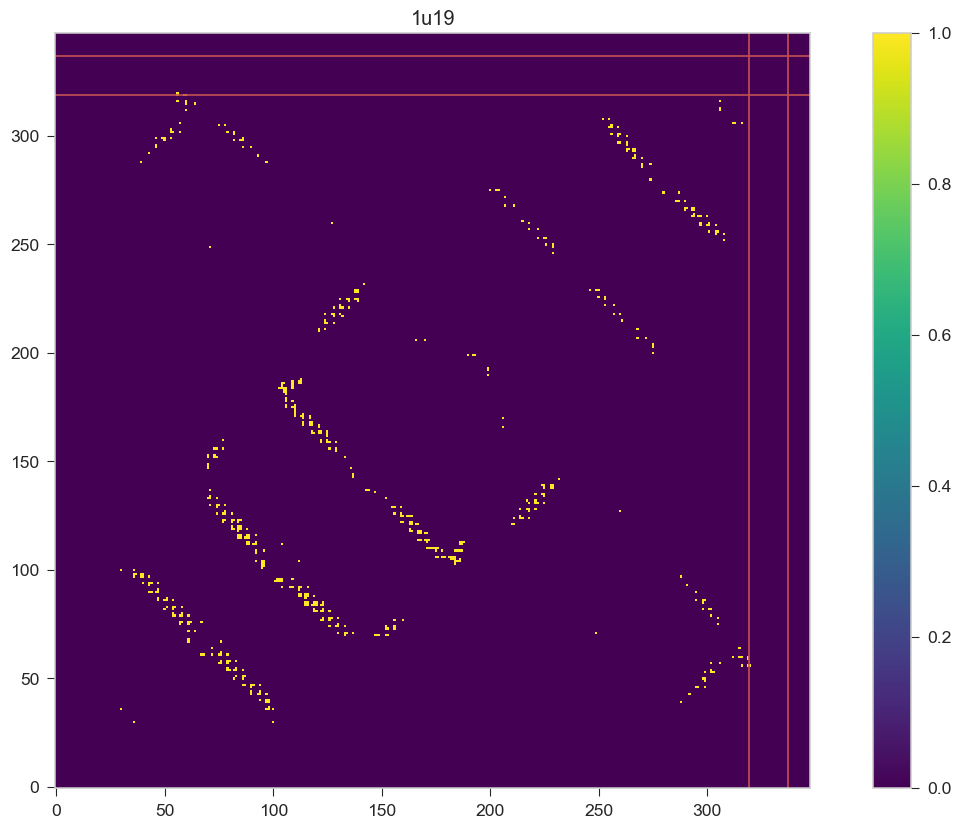

<Figure size 1618.03x1000 with 0 Axes>

In [125]:
for a in d_:
    pdb, t, MembranePart, GlobularPart = a
    plt.imshow((t>0.5).astype(float), origin="bottom")
    plt.colorbar()
    plt.axhline(y=GlobularPart[0], color='r', linestyle='-')
    plt.axhline(y=GlobularPart[-1], color='r', linestyle='-')
    plt.axvline(x=GlobularPart[0], color='r', linestyle='-')
    plt.axvline(x=GlobularPart[-1], color='r', linestyle='-')
    plt.title(pdb)
    plt.savefig(f"/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation/contact_maps/{pdb}_raptor.png")
    plt.figure()

In [114]:
pdb_list = ["2xov_complete", "6e67A", "5xpd", "3kp9", "4a2n", "5d91"]
pdb_list += ["4nv6", "4p79", "5dsg", "6g7o", "6a93", "2jo1", "1py6", "1pv6", "1u19"]
# pdb_list = ["2xov_complete", "6e67A"]
d_ = []
for pdb in pdb_list:
    print(pdb)
    t, MembranePart, GlobularPart = getContactMap(pdb)
    d_.append((pdb, t, MembranePart, GlobularPart))


2xov_complete
6e67A
5xpd
3kp9
4a2n
5d91
4nv6
4p79
5dsg
6g7o
6a93
2jo1
1py6
1pv6
1u19


In [7]:
fileLocation = f"/Users/weilu/Research/raptorX/6g7o/contactmap.txt"
data = pd.read_csv(fileLocation, skiprows=9, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
data["i"] = data["i"].astype(int)
data["j"] = data["j"].astype(int)

In [66]:

n = int(info.query("Protein =='6g7o'")["Length"])

In [67]:
t = np.zeros((n,n))
for index, d in data.iterrows():
#     print(index)
    i = int(d["i"]) - 1
    j = int(d["j"]) - 1 
    p = d["p"]
#     print(i,j,p)
    t[i,j] = p
    t[j,i] = p

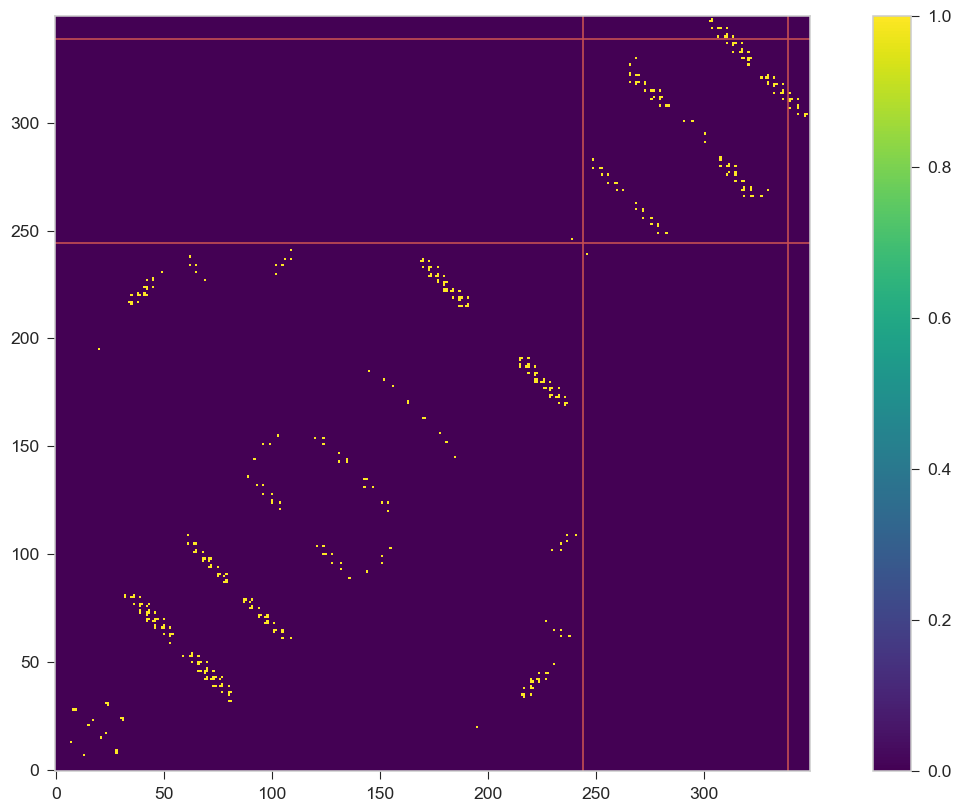

In [106]:
plt.imshow((t>0.5).astype(float), origin="bottom")
plt.colorbar()
plt.axhline(y=GlobularPart[0], color='r', linestyle='-')
plt.axhline(y=GlobularPart[-1], color='r', linestyle='-')
plt.axvline(x=GlobularPart[0], color='r', linestyle='-')
plt.axvline(x=GlobularPart[-1], color='r', linestyle='-')

In [82]:
pdb = "6g7o"
topFile = f"/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation/TM_pred/{pdb}_topo"
MembranePart, GlobularPart = get_two_part_from_prediction(topFile)

In [103]:
MembranePart[0]

25

In [105]:
MembranePart[-1]

238

In [88]:
GlobularPart[0]

244

In [89]:
GlobularPart[-1]

339

In [79]:
GlobularPart

[319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337]

In [80]:
pdb

'1u19'

In [76]:

topFile = f"/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation/TM_pred/{pdb}_topo"
def get_two_part_from_prediction(topFile):
    with open(f"{topFile}") as f:
        a = f.readlines()
    assert len(a) == 3
    res_list = []
    first = None
    count = 1
    previousEnd = 0
    # print("g_all = [")
    topo = a[2].strip()

    cutoff = 30 if pdb != "1py6" else 15
    linkerSize = 10 if pdb != "1py6" else 5
    for i, res in enumerate(topo):
        o = "2" if res == "1" else "1"
        if res == "0":
            if len(res_list) > 0:
                # print(f"g{count} =", res_list)
                # print(res_list, ", ")
                count += 1
                last = res_list[-1]
                first = res_list[0] if first is None else first
                span = res_list[0] - previousEnd
                if span > cutoff:
                    # print(f"{pdb} Globular", previousEnd, res_list[0])
                    globular = list(range(previousEnd+linkerSize, res_list[0]-linkerSize))
                previousEnd = last
            res_list = []
        if res == "1":
            res_list.append(i)
    n = len(topo)
    # print(f"{pdb}: size {n}")
    span = n - previousEnd
    if span > cutoff:
        # print(f"{pdb} Globular", previousEnd, n)
        globular = list(range(previousEnd+linkerSize, n-linkerSize))

    membranePart = []
    for i in range(first-5, last+5):
        if i not in globular:
            membranePart.append(i)
    return membranePart, globular

In [149]:
pdb = "5d91"
fileLocation = f"/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation/cleaned_pdbs/{pdb}.pdb"
parser = PDBParser()
structure = parser.get_structure('target', fileLocation)

In [150]:
all_residues = list(structure.get_residues())

In [143]:
res = all_residues[0]

In [148]:
res["CA"] - res["CA"]

0.0

In [157]:
np.b

array([[1, 0],
       [0, 2]])

In [151]:
n = len(all_residues)
contact_table = np.zeros((n,n))
print(pdb, n)
for i, res1 in enumerate(all_residues):
    for j, res2 in enumerate(all_residues):
        contact_table[i][j] = res1["CA"]-res2["CA"]

5d91 335


In [164]:
cutoff = 9.5
MAX_OFFSET = 6
data = (contact_table < cutoff)

remove_band = np.eye(n)
for i in range(1, MAX_OFFSET):
    remove_band += np.eye(n, k=i)
    remove_band += np.eye(n, k=-i)
data[remove_band==1] = 0

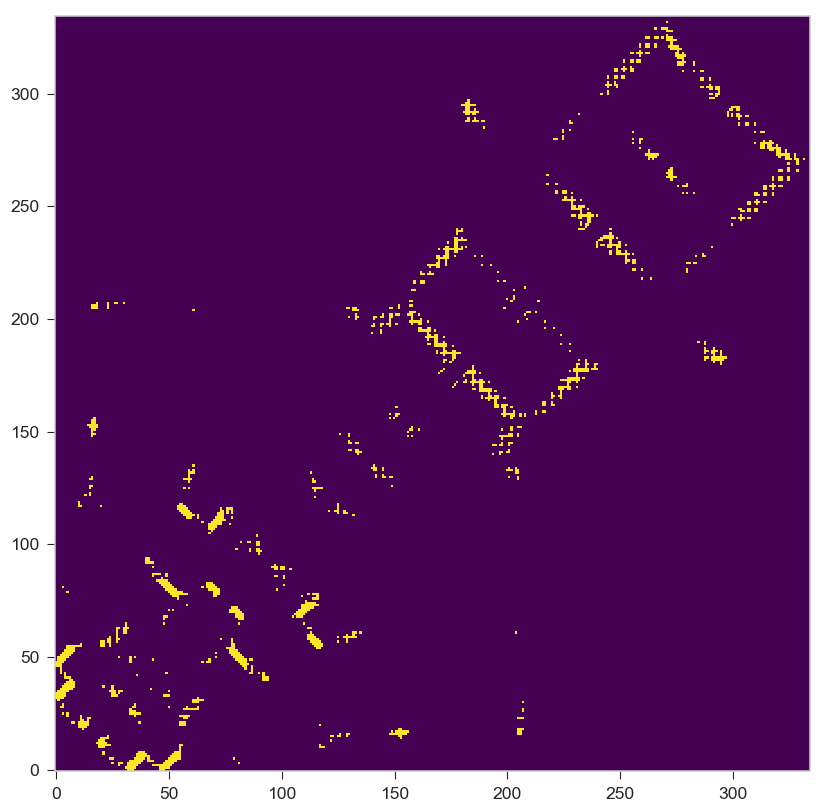

In [165]:
plt.imshow(data, origin="bottom")

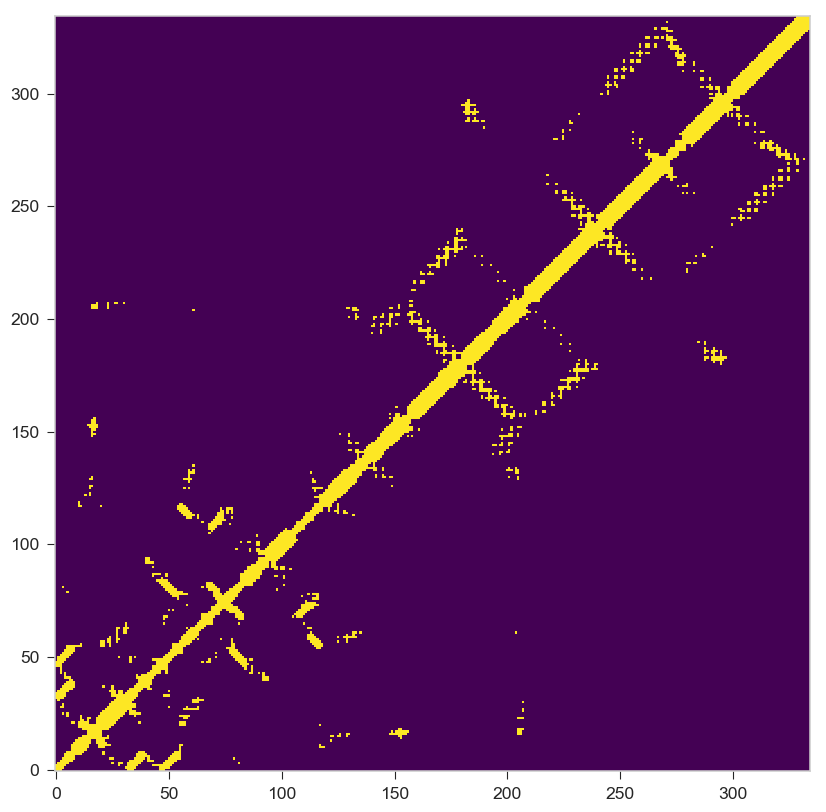

In [154]:
plt.imshow(contact_table < 9.5, origin="bottom")

In [ ]:
with open(f"{probFile}") as f:
    a = f.readlines()
res_list = []
first = None
count = 1
previousEnd = 0
# print("g_all = [")
out = "[\n"
for i, line in enumerate(a[3:]):
    prob = float(line.strip().split()[3])
    res = "0" if prob < 0.5 else "1"
    o = "2" if res == "1" else "1"

    if res == "0":
        if len(res_list) > 0:
            # print(f"g{count} =", res_list)
            print(res_list, ", ")
            out += f"    {res_list},\n"
            count += 1
            last = res_list[-1]
            first = res_list[0] if first is None else first
            span = res_list[0] - previousEnd
            if span > 30:
                print("Globular", previousEnd, res_list[0])
                globular = list(range(previousEnd+10, res_list[0]-10))
            previousEnd = last
        res_list = []
    if res == "1":
        res_list.append(i)
n = len(a[3:])
print(f"size {n}")
span = n - previousEnd
if span > 30:
    print(f" Globular", previousEnd, n)
    globular = list(range(previousEnd+10, n-10))
out += "]\n"

membranePart = []
for i in range(first-5, last+5):
    if i not in globular:
        membranePart.append(i)

In [ ]:
def get_two_part_from_prediction(probFile):
    #   probFile = f"TM_pred/{pdb}_PureTM/{pdb}.prob"
    with open(f"{probFile}") as f:
        a = f.readlines()
    res_list = []
    first = None
    count = 1
    previousEnd = 0
    # print("g_all = [")
    out = "[\n"
    for i, line in enumerate(a[3:]):
        prob = float(line.strip().split()[3])
        res = "0" if prob < 0.5 else "1"
        o = "2" if res == "1" else "1"

        if res == "0":
            if len(res_list) > 0:
                # print(f"g{count} =", res_list)
                print(res_list, ", ")
                out += f"    {res_list},\n"
                count += 1
                last = res_list[-1]
                first = res_list[0] if first is None else first
                span = res_list[0] - previousEnd
                if span > 30:
                    print("Globular", previousEnd, res_list[0])
                    globular = list(range(previousEnd+10, res_list[0]-10))
                previousEnd = last
            res_list = []
        if res == "1":
            res_list.append(i)
    n = len(a[3:])
    print(f"size {n}")
    span = n - previousEnd
    if span > 30:
        print(f" Globular", previousEnd, n)
        globular = list(range(previousEnd+10, n-10))
    out += "]\n"

    membranePart = []
    for i in range(first-5, last+5):
        if i not in globular:
            membranePart.append(i)
    return globular, membranePart

In [25]:
n_i = len(data["i"].unique())
n_j = len(data["j"].unique())
n = data.shape[0]
assert n_i == n_j
assert n_i*(n_i+1)/2 == n

350

In [27]:
def getFromTerminal(CMD):
    return subprocess.Popen(CMD,stdout=subprocess.PIPE,shell=True).communicate()[0].decode()


In [39]:
# get protein length info
pre = "/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation"
cmd = f"wc {pre}/setup/1pv6/ssweight"
a = getFromTerminal(cmd)

In [40]:
length = a.split()[0]

In [41]:
length

'417'

In [44]:
d_ = []
pdb_list = ["2xov_complete", "6e67A", "5xpd", "3kp9", "4a2n", "5d91"]
pdb_list += ["4nv6", "4p79", "5dsg", "6g7o", "6a93", "2jo1", "1py6", "1pv6", "1u19"]
for pdb in pdb_list:
    pre = "/Users/weilu/Research/server/jul_2019/hybrid_protein_simulation"
    cmd = f"wc {pre}/setup/{pdb}/ssweight"
    a = getFromTerminal(cmd)
    length = a.split()[0]
    d_.append([pdb, length])

In [47]:
info = pd.DataFrame(d_, columns=["Protein", "Length"])

In [49]:
info.to_csv(f"{pre}/length_info.csv")